#### Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow import keras

### Global

In [35]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

country_code    country_name
0          AUS       Australia
1          BRA          Brazil
2          CAN           India
3          CHN           China
4          GBR  United Kingdom
5          IND           India
6          JPN           Japan
7          SGP       Singapore
8          USA   United States

### Data

Use (country_code, imputation_method) to store corresponding df
- m_dfs: manufacturing data
- s_dfs: service data

In [3]:
Data_dic_m = pd.ExcelFile('../../Data/cleaned/Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('../../Data/cleaned/Service_filled.xlsx')

In [4]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [5]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df

In [6]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[(sheet[:3], sheet[3:].strip())] = df

### Scaling

In [7]:
class MRobustScaler():
      """
      Scale features using statistics that are robust to outliers.
      """
      def __init__(self, q1=0.2, q2=0.8):
          self.q1 = q1
          self.q2 = q2

      def fit(self, df, eps):
          """
          Return quantile range and median of all features

          Set qrange be 1 if feature has very small range, otherwise calculate
          the quantile range with specified quantile
          """
          df = df.astype('float64') # convert object to float
          self.df_median = df.median() #pd median uses np.nanmedian
          df_q1 = df.quantile(self.q1)
          df_q2 = df.quantile(self.q2)
          qrange = np.array(df_q2 - df_q1) #Near constant features have a very small range
          if np.isscalar(qrange):
                if qrange < eps:
                      qrange = 1.0
          elif isinstance(qrange, np.ndarray):
                constant_mask = qrange < np.ones_like(qrange)*eps
                qrange[constant_mask] = 1.0
          self.qrange = qrange
          self.df_qrange = pd.Series(index = self.df_median.index, data=qrange)
          return self.qrange, self.df_median
      
      def get_fitted(self):
        return self.df_median, self.qrange

      def transform(self, df, eps = 0.1):
          qrange, df_median = self.fit(df, eps = eps)
          return (df - df_median)/qrange

##### ** problem: using quantile scaler, but also median imputation method cause 0

### Make dataset

#### Split dataset 

In [8]:
def train_test_split(df, train_ratio = 0.7, val_ratio = 0.9, IW = 3):
  """
  By default: train:val:test = 0.7:0.2:0.1
  """
  n = len(df)
  train_df = df[0:int(n*train_ratio)]
  val_df = df[(int(n*train_ratio)-IW):int(n*val_ratio)]
  test_df = df[(int(n*val_ratio)-IW):]
  return train_df, val_df, test_df

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, scaled_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.scaled_data = scaled_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def all_data(self):
    return self.make_dataset(self.scaled_data)

#### Model

In [10]:
class LSTM_base:

  def __init__(self, lookback_width, num_features, loss=None, layer1=512, layer2=256, layer3=256, label_width=1):
    self.lookback_width = lookback_width
    self.num_features = num_features
    self.loss = loss 
    self.layer1 = layer1
    self.layer2 = layer2
    self.layer3 = layer3
    self.label_width = label_width
    self.create_model()
    self.history = None

  def create_model(self):
    input = layers.Input(shape=(self.lookback_width, self.num_features), name='input')
    x = layers.LSTM(self.layer1, return_sequences=True)(input)
    x = layers.Dropout(0.05)(x)
    x = layers.LSTM(self.layer2, return_sequences=True)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.LSTM(self.layer3)(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(self.label_width)(x)
    model = keras.Model(input, outputs=output)
    self.model = model

  def compile_and_fit(self, data_window, epochs, batch_size, verbose, learning_rate, patience=4):
    loss=self.loss,
    history = History()
    batch_size = batch_size[0] if isinstance(batch_size, tuple) else batch_size
    self.model.compile(loss=loss,
                       optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    self.history = self.model.fit(data_window.train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=data_window.val, 
                                  callbacks=[history, EarlyStopping(monitor='val_loss',
                                                           patience=patience,
                                                           mode='min',
                                                           restore_best_weights=True)],
                                  verbose=verbose,
                                  shuffle=False)
    return self.history

  def plot(self):
    display(tf.keras.utils.plot_model(self.model, show_shapes=True))
  
  def train(self, data_window, MAX_EPOCHS, bs, verbose, lr, patience):
    start = time()
    self.data_window = data_window
    self.compile_and_fit(data_window=data_window,
                                epochs=MAX_EPOCHS,
                                batch_size=bs,
                                verbose=verbose,
                                learning_rate=lr,
                                patience=patience)
    delta=time()-start
    self.delta = delta
    print('Total Modelling Time: ',delta)

#### Evaluation

MAE, MSE, RMSE, COD (Coefficient of Determination)

In [11]:
def fetch_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.test)
  y_pred = np.array(y_pred)*qrange+target_median
  y_real = np.array([y*qrange+target_median for _, y in model.data_window.test]).reshape(y_pred.shape)
  return y_pred, y_real

In [12]:
def MAE(y_pred, y_real, verbose = 1):
  E = y_pred-y_real
  return np.mean(np.abs(E), axis = 0), np.mean(np.abs(E))

def MSE(y_pred, y_real):
  E = y_pred-y_real
  return np.mean(np.square(E), axis = 0), np.mean(np.square(E))

def RMSE(y_pred, y_real):
  np.sqrt(MSE(y_pred, y_real)[0])
  return np.sqrt(MSE(y_pred, y_real)[0]), np.sqrt(MSE(y_pred, y_real)[1])

In [13]:
def fetch_all_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.all_data)
  y_pred = np.array(y_pred)*qrange+target_median
  y = None
  for _, j in  model.data_window.all_data:
    if y is None:
      y = j*qrange+target_median
    else:
      y = np.concatenate((y, j*qrange+target_median))
  y_real = y.reshape(y_pred.shape)
  return y_pred, y_real

In [14]:
def pat_pred(y, data):
  """
  y could be y_real or y_pred
  """
  d = pd.DataFrame({})
  for i in range(y.shape[1]):
    d[f'gap_{i}'] =  [np.nan] * i + list(y[:, i]) + [np.nan] * (y.shape[1]-i-1)
  d.index = data[IW:].index
  return d

In [15]:
def forecast(rbscaler, scaled_data, model, name = 'Manufacturing_value added_%_of_GDP'):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y = model.model.predict(np.expand_dims(scaled_data.iloc[-3:, :], axis = 0))
  df =  pd.DataFrame({name: (np.array(y)*qrange+target_median).tolist()[0]}, index =  [scaled_data.index[-1]+i for i in range(1, 6)])
  return df

### Pipeline

Pipeline example of china, median

In [16]:
SHIFT = 5
LW = 5
IW = 3
MAX_EPOCHS = 50
bs = 32
verbose = True
lr = 0.001
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()

In [17]:
data = m_dfs[('CHN', 'Median')]
rbscaler = MRobustScaler() 
scaled_data = rbscaler.transform(data, 0.1)

In [18]:
train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
# use 4 year to predict 1 year ahead
wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                     train_df = train_df, val_df = val_df, test_df = test_df, 
                     scaled_data = scaled_data,
                     label_columns=[scaled_data.columns[-1]])
wg

Total window size: 8
Input indices: [0 1 2]
Label indices: [3 4 5 6 7]
Label column name(s): ['Manufacturing_value added_%_of_GDP']

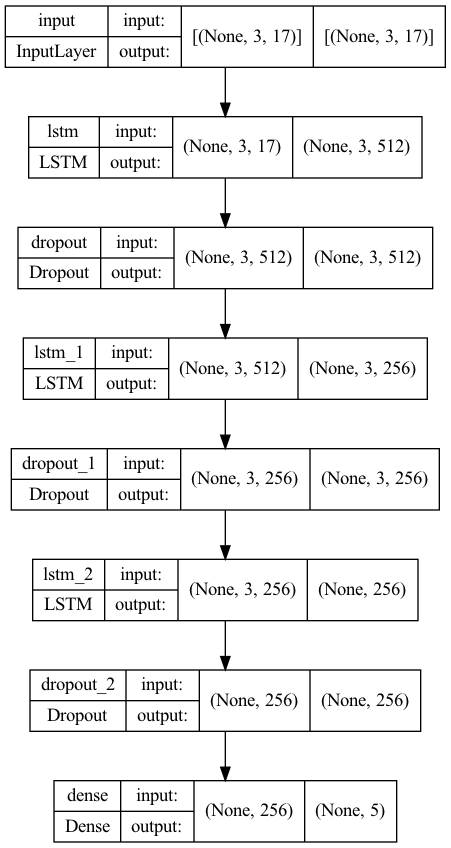

In [19]:
model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
model.plot()
# !brew install graphviz # for mac
# !pip install pydot

In [20]:
model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2144 - val_loss: 1.2982
Epoch 2/50
1/1 [==============================] - 0s 137ms/step - loss: 0.2210 - val_loss: 1.2943
Epoch 3/50
1/1 [==============================] - 0s 82ms/step - loss: 0.2175 - val_loss: 1.2916
Epoch 4/50
1/1 [==============================] - 0s 76ms/step - loss: 0.2136 - val_loss: 1.2869
Epoch 5/50
1/1 [==============================] - 0s 73ms/step - loss: 0.2099 - val_loss: 1.2823
Epoch 6/50
1/1 [==============================] - 0s 73ms/step - loss: 0.2078 - val_loss: 1.2772
Epoch 7/50
1/1 [==============================] - 0s 136ms/step - loss: 0.2050 - val_loss: 1.2688
Epoch 8/50
1/1 [==============================] - 0s 76ms/step - loss: 0.2014 - val_loss: 1.2548
Epoch 9/50
1/1 [==============================] - 0s 76ms/step - loss: 0.1976 - val_loss: 1.2350
Epoch 10/50
1/1 [==============================] - 0s 72ms/step - loss: 0.1903 - val_loss: 1.2086
Epoch 11/50
1/1 [============

In [21]:
y_pred, y_real = fetch_pred_real(rbscaler, model)
print(
'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
'\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
'\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
)

MAE [1.60923, 2.0618236, 2.6722562, 3.3186722, 3.5564616]  Mean MAE 2.643689 
MSE [3.8890038, 5.4423714, 8.167224, 11.597787, 12.974198]  Mean MSE 8.414117 
RMSE [1.9720557, 2.332889, 2.8578355, 3.4055524, 3.6019714] Mean RMSE 2.9007096


In [23]:
pat_pred

<function __main__.pat_pred(y, data)>

In [25]:
y_pred, y_real = fetch_all_pred_real(rbscaler, model)
### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
pd.concat([data.iloc[:, -1], pat_pred(y_pred)], axis = 1).plot(figsize = (20, 4), title = 'China')

TypeError: pat_pred() missing 1 required positional argument: 'data'

In [26]:
forecast(rbscaler, model)

TypeError: forecast() missing 1 required positional argument: 'model'

#### pipeline function

In [29]:
SHIFT = 5
LW = 5
IW = 3
MAX_EPOCHS = 50
bs = 32
verbose = False
lr = 0.001
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()

In [30]:
def pipeline(country = 'CHN', method = 'Median'):
  data = m_dfs[(country, method)].dropna(axis = 1)
  rbscaler = MRobustScaler() 
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
  )
  y_pred1, y_real1 = fetch_all_pred_real(rbscaler, model)
  ### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
  display(pd.concat([data.iloc[:, -1], pat_pred(y_pred1, data)], axis = 1).plot(figsize = (20, 4), title = dic_country[country] + ' (' +  method + ') :' \
                                                                         + '\nMean MAE: ' + str(MAE(y_pred, y_real)[1]) \
                                                                         + '\nMean MSE: ' + str(MSE(y_pred, y_real)[1]) \
                                                                         + '\nMean RMSE: ' + str(RMSE(y_pred, y_real)[1]) \
                                                                         ))
  display(forecast(rbscaler, scaled_data, model, name = country + '_' + method))
  return  MAE(y_pred, y_real)[1], MSE(y_pred, y_real)[1], RMSE(y_pred, y_real)[1]

Total Modelling Time:  7.473870038986206
MAE [1.5828367, 2.057567, 2.6914017, 3.3405287, 3.576362]  Mean MAE 2.6497393 
MSE [3.7789738, 5.392363, 8.2853985, 11.739284, 13.113373]  Mean MSE 8.461878 
RMSE [1.9439583, 2.3221462, 2.8784368, 3.4262638, 3.6212392] Mean RMSE 2.9089308


<AxesSubplot:title={'center':'China (Median) :\nMean MAE: 2.6497393\nMean MSE: 8.461878\nMean RMSE: 2.9089308'}, xlabel='Year'>

CHN_Median
2022   31.011074
2023   30.953127
2024   30.904119
2025   30.754704
2026   30.631432

(2.6497393, 8.461878, 2.9089308)

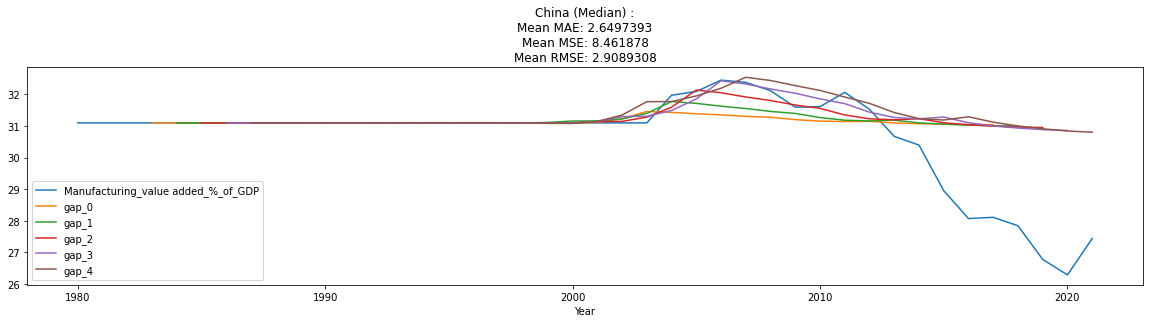

In [31]:
pipeline()

#### Run all pipelines

##### Manufacturing

In [32]:
c, m, a, s, r = [], [], [], [], []

###### Mean

Australia Mean :
Total Modelling Time:  7.947133779525757
MAE [4.0829883, 5.104381, 5.6464767, 5.9554768, 5.908323]  Mean MAE 5.3395286 
MSE [17.092142, 28.484556, 36.743004, 41.122173, 41.226517]  Mean MSE 32.933678 
RMSE [4.1342645, 5.3370924, 6.0616007, 6.4126573, 6.420788] Mean RMSE 5.738787


<AxesSubplot:title={'center':'Australia (Mean) :\nMean MAE: 5.3395286\nMean MSE: 32.933678\nMean RMSE: 5.738787'}, xlabel='Year'>

AUS_Mean
2022  3.246741
2023  2.271887
2024  2.068850
2025  1.895899
2026  2.912082



Brazil Mean :
Total Modelling Time:  7.785906791687012
MAE [12.512401, 12.06435, 14.039952, 13.282158, 7.7453556]  Mean MAE 11.9288435 
MSE [157.56473, 146.95514, 198.66187, 177.23851, 61.25443]  Mean MSE 148.33495 
RMSE [12.552479, 12.122505, 14.094746, 13.313095, 7.826521] Mean RMSE 12.179283


<AxesSubplot:title={'center':'Brazil (Mean) :\nMean MAE: 11.9288435\nMean MSE: 148.33495\nMean RMSE: 12.179283'}, xlabel='Year'>

BRA_Mean
2022   7.577979
2023   8.235199
2024   9.694431
2025  11.343749
2026  13.019986



India Mean :
Total Modelling Time:  7.922688007354736
MAE [1.140925, 0.6281932, 0.572131, 0.8328087, 1.6116337]  Mean MAE 0.9571383 
MSE [1.6677765, 0.53596276, 0.48257506, 0.90632725, 3.8636734]  Mean MSE 1.4912628 
RMSE [1.2914242, 0.73209476, 0.6946762, 0.9520122, 1.9656229] Mean RMSE 1.2211727


<AxesSubplot:title={'center':'India (Mean) :\nMean MAE: 0.9571383\nMean MSE: 1.4912628\nMean RMSE: 1.2211727'}, xlabel='Year'>

CAN_Mean
2022  13.018983
2023  14.371756
2024  18.162210
2025  19.831692
2026  21.336277



China Mean :
Total Modelling Time:  8.341453075408936
MAE [1.1968946, 1.3139194, 1.6944472, 2.3378613, 2.532159]  Mean MAE 1.8150563 
MSE [1.860479, 2.341562, 3.7083626, 5.8692107, 6.6496525]  Mean MSE 4.0858536 
RMSE [1.3639938, 1.5302163, 1.9257109, 2.4226453, 2.578692] Mean RMSE 2.0213494


<AxesSubplot:title={'center':'China (Mean) :\nMean MAE: 1.8150563\nMean MSE: 4.0858536\nMean RMSE: 2.0213494'}, xlabel='Year'>

CHN_Mean
2022  30.081177
2023  29.973335
2024  29.723186
2025  29.455986
2026  29.197289



United Kingdom Mean :
Total Modelling Time:  7.818456172943115
MAE [2.4614806, 2.6600268, 2.8637612, 3.255476, 3.509016]  Mean MAE 2.9499526 
MSE [8.890729, 10.837807, 12.140918, 14.836722, 16.230242]  Mean MSE 12.587283 
RMSE [2.9817326, 3.2920823, 3.484382, 3.8518467, 4.0286775] Mean RMSE 3.547856


<AxesSubplot:title={'center':'United Kingdom (Mean) :\nMean MAE: 2.9499526\nMean MSE: 12.587283\nMean RMSE: 3.547856'}, xlabel='Year'>

GBR_Mean
2022  12.733757
2023  12.976412
2024  13.036519
2025  13.233017
2026  13.360004



India Mean :
Total Modelling Time:  8.097459316253662
MAE [0.5749243, 0.7761995, 1.2543303, 1.5701417, 2.0140862]  Mean MAE 1.2379364 
MSE [0.46746174, 0.7427166, 2.450858, 3.7852166, 4.9128]  Mean MSE 2.4718106 
RMSE [0.6837117, 0.8618101, 1.5655217, 1.9455633, 2.2164836] Mean RMSE 1.5721992


<AxesSubplot:title={'center':'India (Mean) :\nMean MAE: 1.2379364\nMean MSE: 2.4718106\nMean RMSE: 1.5721992'}, xlabel='Year'>

IND_Mean
2022  16.025320
2023  16.196335
2024  15.726290
2025  15.613052
2026  15.532472



Japan Mean :
Total Modelling Time:  7.884197950363159
MAE [0.94214886, 1.2367903, 1.1408316, 1.170229, 1.1673349]  Mean MAE 1.131467 
MSE [1.3579353, 1.9367142, 1.6314892, 1.5047208, 1.5081973]  Mean MSE 1.5878114 
RMSE [1.1653048, 1.3916588, 1.2772976, 1.2266706, 1.2280868] Mean RMSE 1.2600839


<AxesSubplot:title={'center':'Japan (Mean) :\nMean MAE: 1.131467\nMean MSE: 1.5878114\nMean RMSE: 1.2600839'}, xlabel='Year'>

JPN_Mean
2022  20.722601
2023  20.044424
2024  19.668039
2025  19.466942
2026  19.535559



Singapore Mean :
Total Modelling Time:  7.997499942779541
MAE [3.906559, 3.247903, 3.1083593, 3.0767038, 2.4263554]  Mean MAE 3.1531763 
MSE [15.508601, 12.472701, 11.491904, 10.978332, 7.0807214]  Mean MSE 11.506452 
RMSE [3.938096, 3.531671, 3.389971, 3.3133566, 2.6609626] Mean RMSE 3.392116


<AxesSubplot:title={'center':'Singapore (Mean) :\nMean MAE: 3.1531763\nMean MSE: 11.506452\nMean RMSE: 3.392116'}, xlabel='Year'>

SGP_Mean
2022  20.576586
2023  20.374374
2024  20.670465
2025  21.653757
2026  22.657347



United States Mean :
Total Modelling Time:  8.715590000152588
MAE [0.7045355, 0.98310214, 0.6648542, 0.38623652, 0.63614446]  Mean MAE 0.67497456 
MSE [0.5042936, 0.9832311, 0.46773043, 0.17459226, 0.68252]  Mean MSE 0.5624734 
RMSE [0.71013635, 0.9915801, 0.6839082, 0.4178424, 0.8261477] Mean RMSE 0.7499823


<AxesSubplot:title={'center':'United States (Mean) :\nMean MAE: 0.67497456\nMean MSE: 0.5624734\nMean RMSE: 0.7499823'}, xlabel='Year'>

USA_Mean
2022  11.753555
2023  12.662269
2024  14.593728
2025  15.694991
2026  16.249800

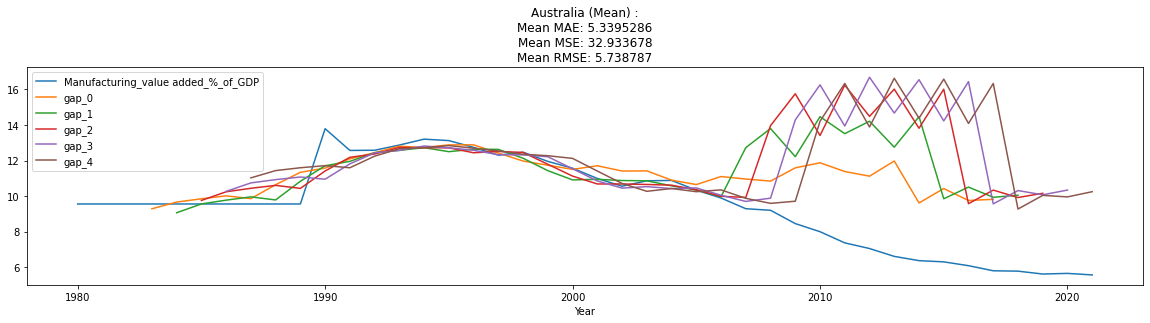

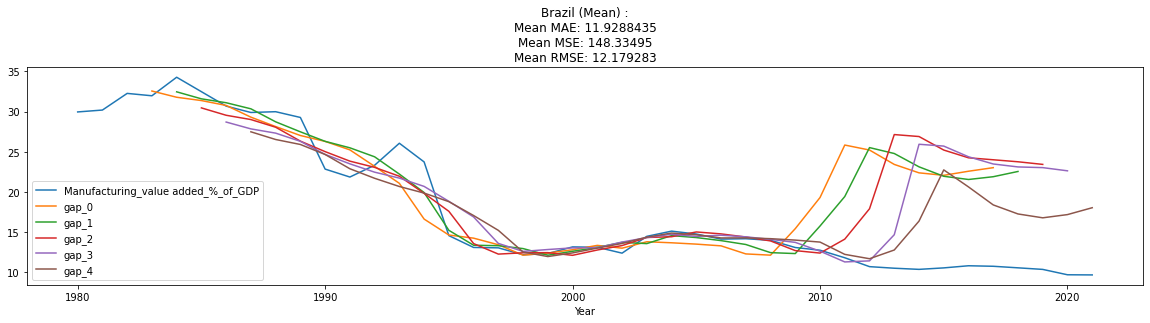

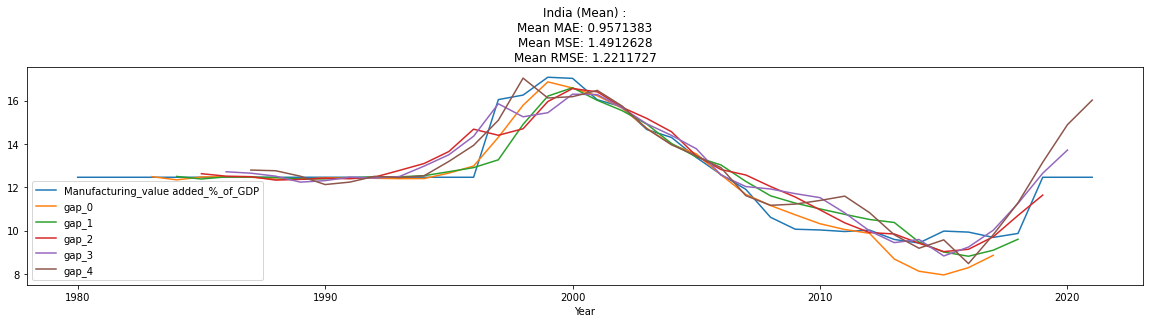

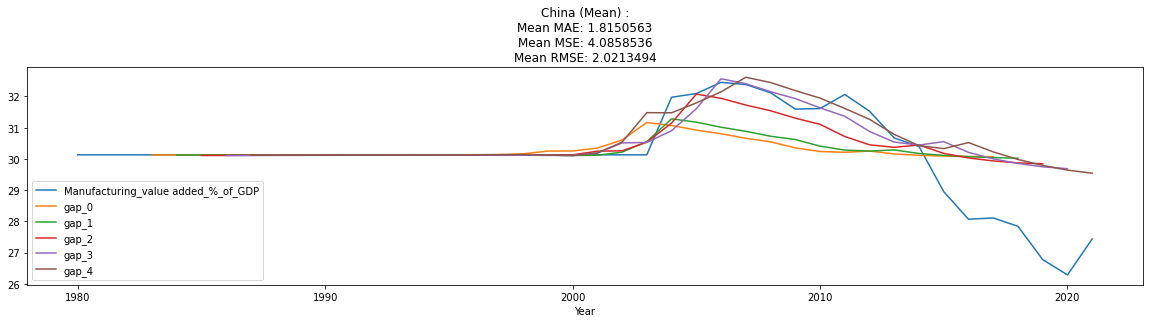

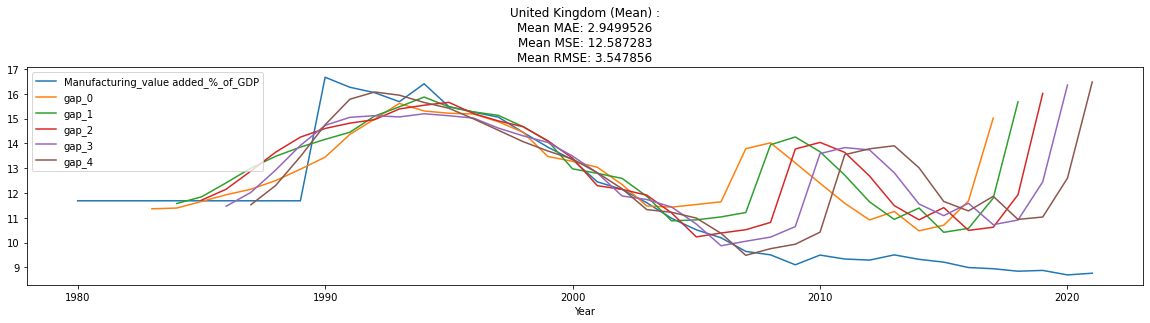

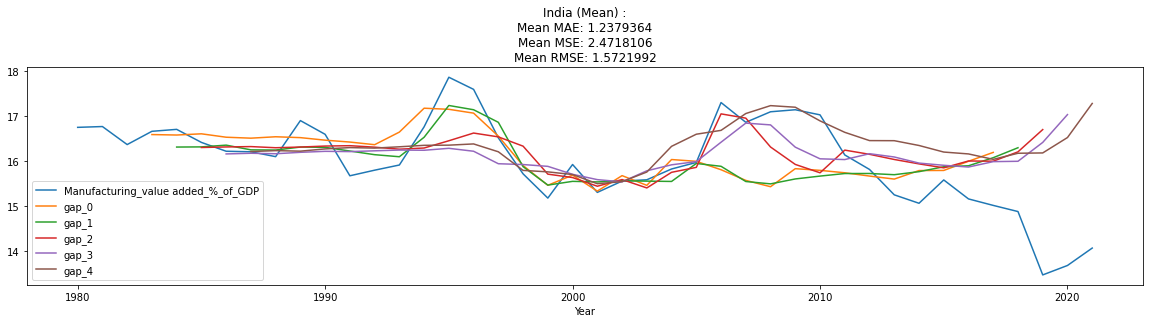

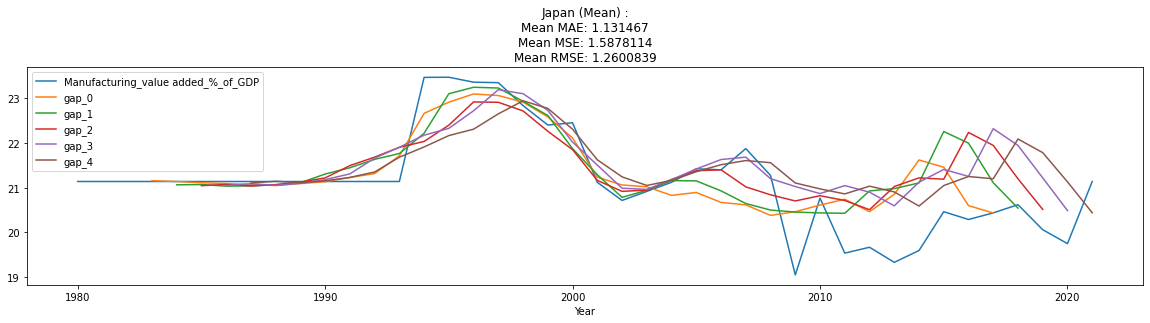

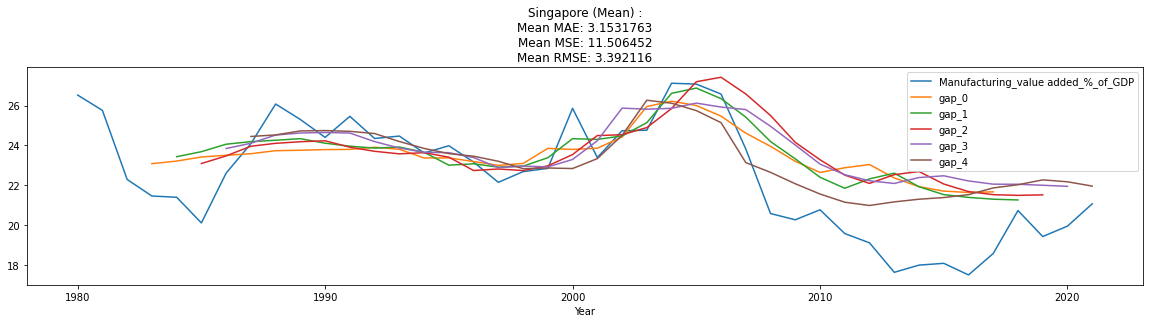

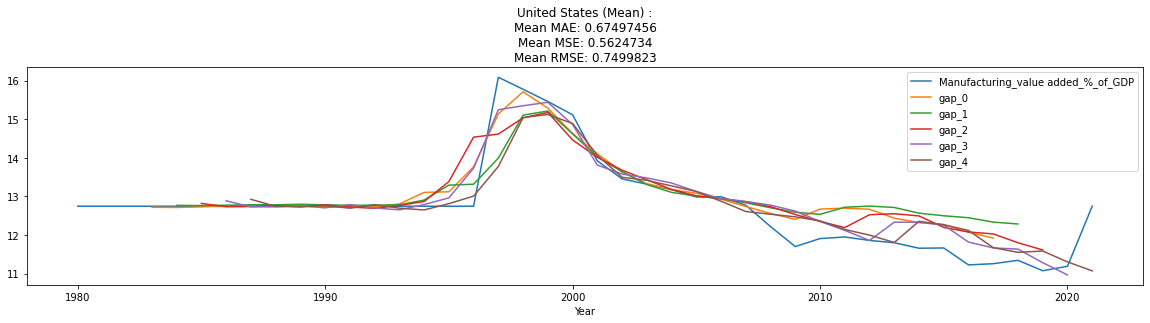

In [36]:
for sheet in get_sheet_by_methods(Data_dic_m, 0):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### Median

Australia Median :
Total Modelling Time:  8.862728834152222
MAE [3.9142487, 4.923151, 5.2936416, 5.7002354, 5.9806914]  Mean MAE 5.162394 
MSE [15.884496, 26.77048, 31.332651, 36.16502, 40.528313]  Mean MSE 30.13619 
RMSE [3.9855359, 5.17402, 5.5975575, 6.013736, 6.366185] Mean RMSE 5.489644


<AxesSubplot:title={'center':'Australia (Median) :\nMean MAE: 5.162394\nMean MSE: 30.13619\nMean RMSE: 5.489644'}, xlabel='Year'>

AUS_Median
2022    9.088307
2023    8.929863
2024    8.833282
2025    8.998542
2026    9.230606



Brazil Median :
Total Modelling Time:  8.52055025100708
MAE [19.95233, 15.039716, 17.275545, 16.855139, 10.758373]  Mean MAE 15.97622 
MSE [399.17233, 228.41438, 301.57715, 285.82898, 118.07447]  Mean MSE 266.61346 
RMSE [19.979298, 15.113384, 17.365976, 16.906477, 10.866208] Mean RMSE 16.328302


<AxesSubplot:title={'center':'Brazil (Median) :\nMean MAE: 15.97622\nMean MSE: 266.61346\nMean RMSE: 16.328302'}, xlabel='Year'>

BRA_Median
2022    6.653988
2023    8.260670
2024    8.852968
2025   10.480411
2026   12.134784



India Median :
Total Modelling Time:  8.655131101608276
MAE [1.9330397, 1.8310257, 1.8691865, 1.9638582, 1.7869296]  Mean MAE 1.8768078 
MSE [4.1377387, 4.019234, 4.0881705, 4.5570736, 3.6554224]  Mean MSE 4.0915275 
RMSE [2.0341432, 2.0048027, 2.0219226, 2.1347303, 1.9119159] Mean RMSE 2.0227525


<AxesSubplot:title={'center':'India (Median) :\nMean MAE: 1.8768078\nMean MSE: 4.0915275\nMean RMSE: 2.0227525'}, xlabel='Year'>

CAN_Median
2022   13.749261
2023   16.350040
2024   17.764313
2025   19.110271
2026   19.947863



China Median :
Total Modelling Time:  8.171544075012207
MAE [1.6193441, 2.0585833, 2.6602395, 3.326422, 3.565134]  Mean MAE 2.645944 
MSE [3.9324894, 5.4078517, 8.083434, 11.655416, 13.030735]  Mean MSE 8.421987 
RMSE [1.9830506, 2.3254788, 2.843138, 3.414003, 3.6098108] Mean RMSE 2.902066


<AxesSubplot:title={'center':'China (Median) :\nMean MAE: 2.645944\nMean MSE: 8.421987\nMean RMSE: 2.902066'}, xlabel='Year'>

CHN_Median
2022   31.112890
2023   30.975546
2024   30.823881
2025   30.762829
2026   30.583139



United Kingdom Median :
Total Modelling Time:  8.307430028915405
MAE [1.6423959, 1.9795524, 2.1186283, 2.4682038, 2.400346]  Mean MAE 2.1218252 
MSE [7.0483284, 10.776731, 11.077846, 12.811803, 11.218753]  Mean MSE 10.586692 
RMSE [2.6548688, 3.282793, 3.3283398, 3.5793579, 3.3494406] Mean RMSE 3.2537198


<AxesSubplot:title={'center':'United Kingdom (Median) :\nMean MAE: 2.1218252\nMean MSE: 10.586692\nMean RMSE: 3.2537198'}, xlabel='Year'>

GBR_Median
2022   12.179509
2023   12.641829
2024   12.570210
2025   12.491866
2026   12.327714



India Median :
Total Modelling Time:  9.109816074371338
MAE [0.5233399, 0.71713704, 1.3149548, 1.2969702, 1.7625238]  Mean MAE 1.1229851 
MSE [0.36320686, 0.5966077, 2.2897036, 2.557965, 3.6684077]  Mean MSE 1.8951781 
RMSE [0.60266644, 0.77240384, 1.5131767, 1.5993639, 1.9153087] Mean RMSE 1.3766546


<AxesSubplot:title={'center':'India (Median) :\nMean MAE: 1.1229851\nMean MSE: 1.8951781\nMean RMSE: 1.3766546'}, xlabel='Year'>

IND_Median
2022   15.975257
2023   16.104216
2024   15.688307
2025   15.485623
2026   15.385479



Japan Median :
Total Modelling Time:  8.6353600025177
MAE [0.9307378, 1.0949278, 0.87457246, 0.83512783, 0.9741316]  Mean MAE 0.9418995 
MSE [1.3429133, 1.5038499, 1.2591116, 0.8800767, 1.0221123]  Mean MSE 1.2016126 
RMSE [1.1588414, 1.2263156, 1.1221014, 0.93812406, 1.0109956] Mean RMSE 1.0961809


<AxesSubplot:title={'center':'Japan (Median) :\nMean MAE: 0.9418995\nMean MSE: 1.2016126\nMean RMSE: 1.0961809'}, xlabel='Year'>

JPN_Median
2022   20.546667
2023   19.817743
2024   19.450462
2025   19.234221
2026   19.039431



Singapore Median :
Total Modelling Time:  9.194388151168823
MAE [4.414696, 3.931515, 3.947878, 3.6268702, 2.7096634]  Mean MAE 3.7261248 
MSE [19.687632, 17.164513, 17.15512, 14.570385, 8.6163435]  Mean MSE 15.4388 
RMSE [4.4370747, 4.1430078, 4.141874, 3.8171175, 2.935361] Mean RMSE 3.9292238


<AxesSubplot:title={'center':'Singapore (Median) :\nMean MAE: 3.7261248\nMean MSE: 15.4388\nMean RMSE: 3.9292238'}, xlabel='Year'>

SGP_Median
2022   21.206585
2023   21.005674
2024   21.661766
2025   22.038797
2026   22.687319



United States Median :
Total Modelling Time:  9.537396907806396
MAE [0.2847775, 0.16400258, 0.32926893, 0.6878721, 0.9827382]  Mean MAE 0.48973185 
MSE [0.09322891, 0.04275422, 0.13776934, 0.61782795, 1.4420556]  Mean MSE 0.4667272 
RMSE [0.3053341, 0.20677094, 0.37117293, 0.78602034, 1.2008562] Mean RMSE 0.6831744


<AxesSubplot:title={'center':'United States (Median) :\nMean MAE: 0.48973185\nMean MSE: 0.4667272\nMean RMSE: 0.6831744'}, xlabel='Year'>

USA_Median
2022   10.823888
2023   11.529215
2024   12.425241
2025   13.109497
2026   13.880483

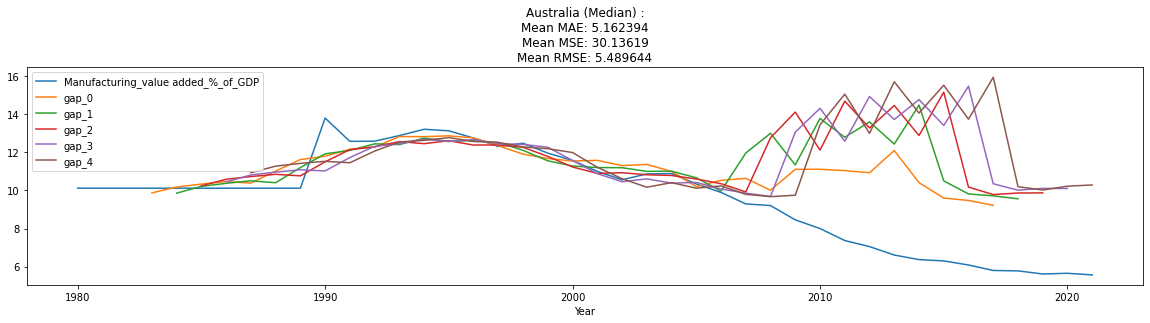

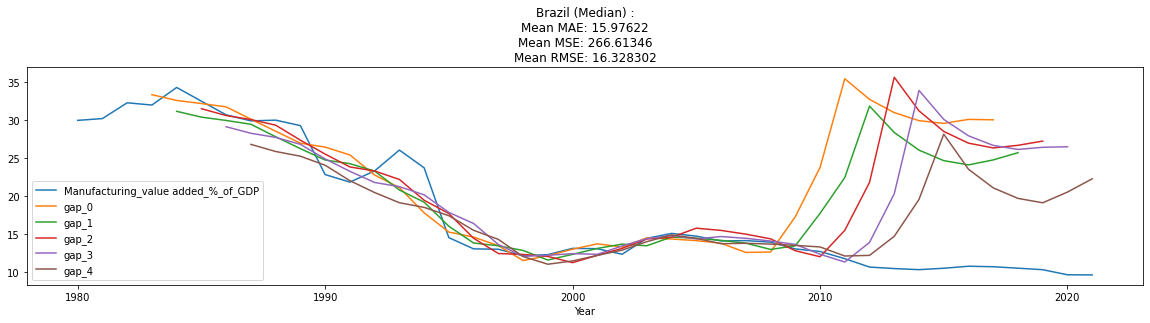

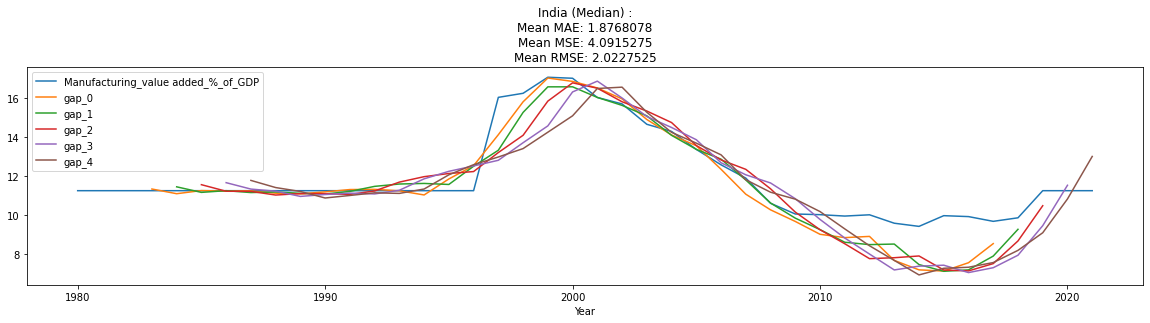

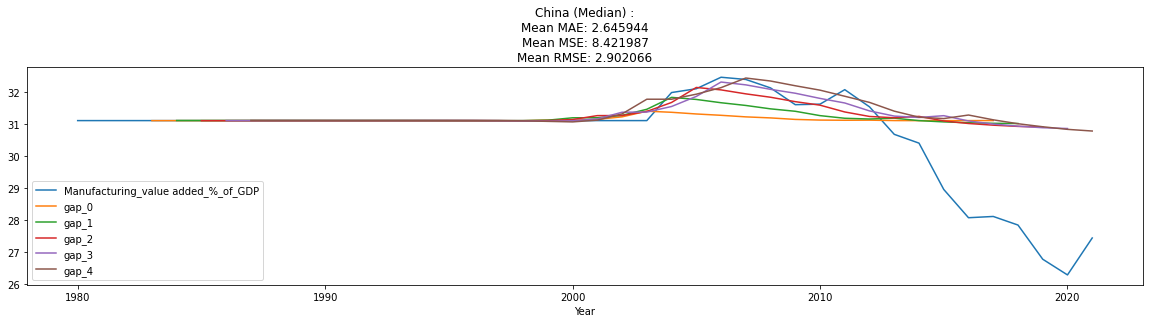

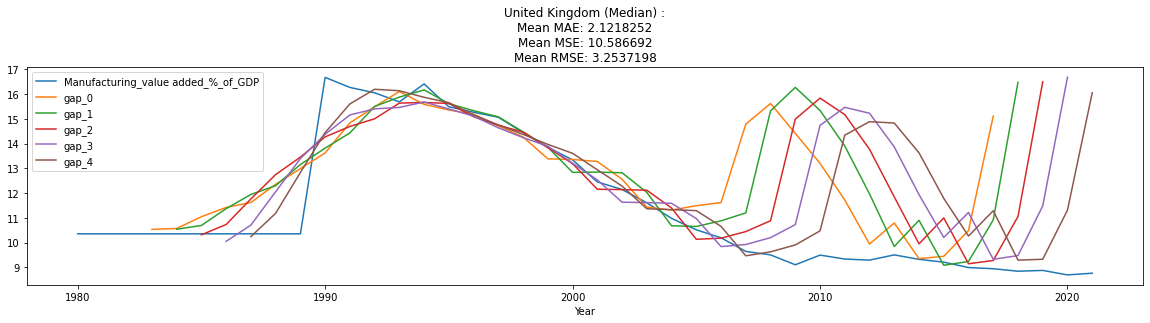

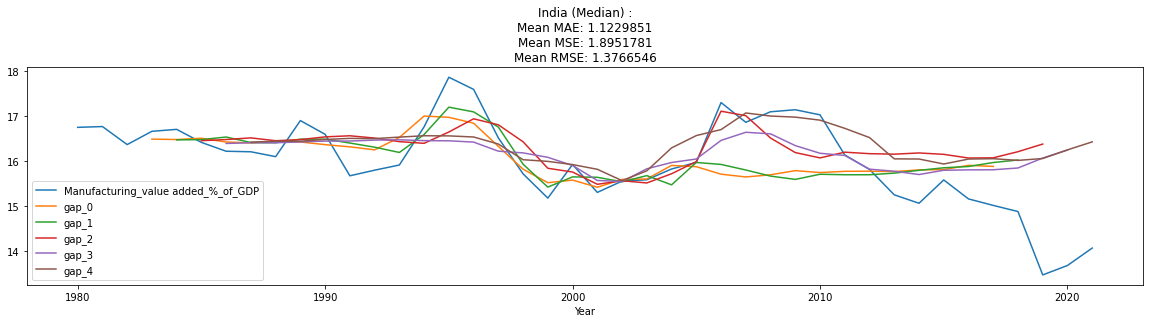

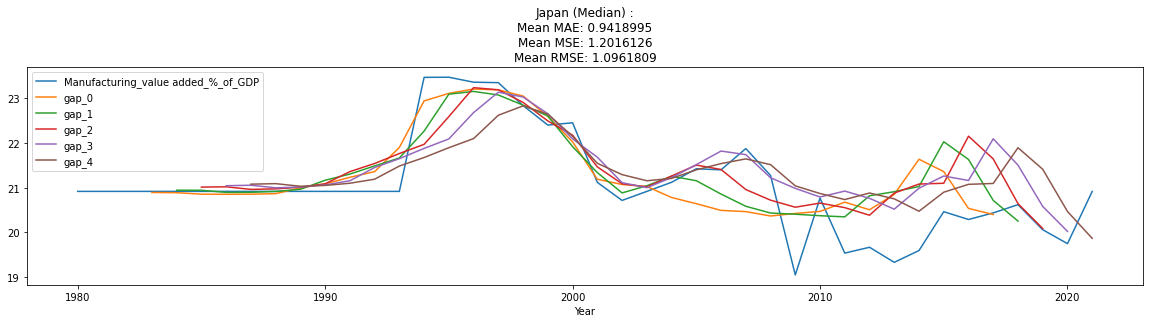

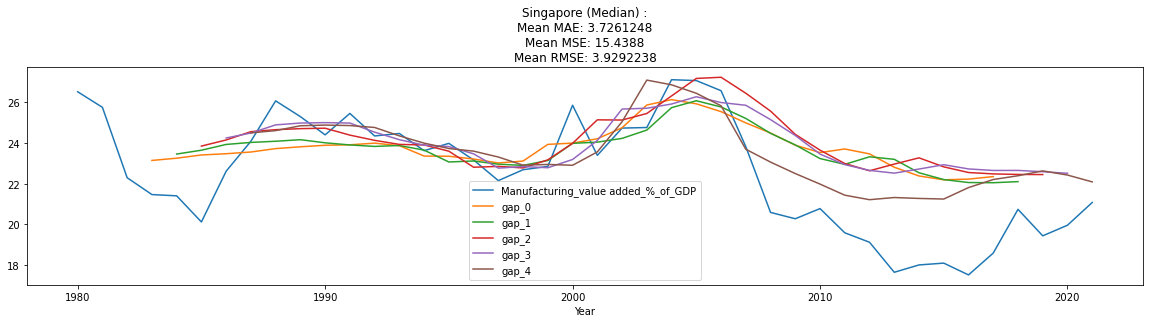

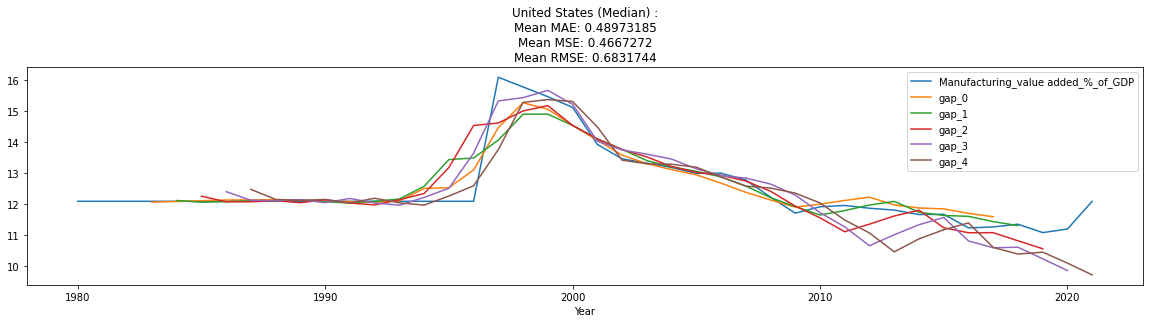

In [37]:
for sheet in get_sheet_by_methods(Data_dic_m, 1):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### LOCF

Australia LOCF :
Total Modelling Time:  9.41154670715332
MAE [534966270000.0, 522259270000.0, 472643960000.0, 403551700000.0, 398329540000.0]  Mean MAE 466350150000.0 
MSE [2.8784134e+23, 2.7722293e+23, 2.2850276e+23, 1.6908734e+23, 1.7107957e+23]  Mean MSE 2.2674678e+23 
RMSE [536508470000.0, 526519630000.0, 478019620000.0, 411202320000.0, 413617650000.0] Mean RMSE 476179370000.0


<AxesSubplot:title={'center':'Australia (LOCF) :\nMean MAE: 466350150000.0\nMean MSE: 2.2674678e+23\nMean RMSE: 476179370000.0'}, xlabel='Year'>

AUS_LOCF
2022  3.221038e+11
2023  3.117877e+11
2024  3.423310e+11
2025  3.770237e+11
2026  3.963435e+11



Brazil LOCF :
Total Modelling Time:  10.044910907745361
MAE [0.81005126, 1.9716202, 2.8981087, 4.9640317, 5.6816773]  Mean MAE 3.2650979 
MSE [0.91342205, 4.7884583, 9.62806, 27.303505, 36.316196]  Mean MSE 15.789928 
RMSE [0.95573115, 2.1882546, 3.1029115, 5.2252755, 6.0262923] Mean RMSE 3.9736543


<AxesSubplot:title={'center':'Brazil (LOCF) :\nMean MAE: 3.2650979\nMean MSE: 15.789928\nMean RMSE: 3.9736543'}, xlabel='Year'>

BRA_LOCF
2022  10.890749
2023  11.502983
2024  11.747030
2025  11.945047
2026  11.835225



India LOCF :
Total Modelling Time:  9.365553140640259
MAE [559724800000.0, 476472670000.0, 466621730000.0, 351698600000.0, 323603760000.0]  Mean MAE 435624380000.0 
MSE [3.186902e+23, 2.3430627e+23, 2.2664918e+23, 1.3162199e+23, 1.20633375e+23]  Mean MSE 2.063802e+23 
RMSE [564526500000.0, 484051940000.0, 476076870000.0, 362797430000.0, 347323170000.0] Mean RMSE 454290870000.0


<AxesSubplot:title={'center':'India (LOCF) :\nMean MAE: 435624380000.0\nMean MSE: 2.063802e+23\nMean RMSE: 454290870000.0'}, xlabel='Year'>

CAN_LOCF
2022  6.345164e+11
2023  6.250688e+11
2024  5.900120e+11
2025  6.305787e+11
2026  7.113900e+11



China LOCF :
Total Modelling Time:  9.479014873504639
MAE [1997429900000.0, 2581573000000.0, 2243265600000.0, 2493361700000.0, 1992469900000.0]  Mean MAE 2261619800000.0 
MSE [4.047421e+24, 6.7990704e+24, 5.111756e+24, 6.2899927e+24, 4.0600284e+24]  Mean MSE 5.2616536e+24 
RMSE [2011820300000.0, 2607502600000.0, 2260919400000.0, 2507986000000.0, 2014951200000.0] Mean RMSE 2293829500000.0


<AxesSubplot:title={'center':'China (LOCF) :\nMean MAE: 2261619800000.0\nMean MSE: 5.2616536e+24\nMean RMSE: 2293829500000.0'}, xlabel='Year'>

CHN_LOCF
2022  5.676312e+12
2023  5.489194e+12
2024  6.950640e+12
2025  7.245323e+12
2026  8.706734e+12



United Kingdom LOCF :
Total Modelling Time:  8.937212228775024
MAE [523337700000.0, 305350300000.0, 128190340000.0, 110896310000.0, 310198570000.0]  Mean MAE 275594640000.0 
MSE [2.9069676e+23, 1.02478e+23, 2.5696119e+22, 2.048117e+22, 1.1495255e+23]  Mean MSE 1.10860915e+23 
RMSE [539163030000.0, 320121860000.0, 160300090000.0, 143112440000.0, 339046530000.0] Mean RMSE 332957840000.0


<AxesSubplot:title={'center':'United Kingdom (LOCF) :\nMean MAE: 275594640000.0\nMean MSE: 1.10860915e+23\nMean RMSE: 332957840000.0'}, xlabel='Year'>

GBR_LOCF
2022  1.400830e+12
2023  1.430118e+12
2024  1.514703e+12
2025  1.616106e+12
2026  1.778136e+12



India LOCF :
Total Modelling Time:  9.663908958435059
MAE [0.38087162, 0.24869029, 0.90642184, 1.0566643, 1.818385]  Mean MAE 0.88220656 
MSE [0.2183028, 0.08170701, 1.3933951, 1.8900094, 4.2066116]  Mean MSE 1.5580052 
RMSE [0.46722886, 0.2858444, 1.1804216, 1.3747761, 2.0510025] Mean RMSE 1.2482008


<AxesSubplot:title={'center':'India (LOCF) :\nMean MAE: 0.88220656\nMean MSE: 1.5580052\nMean RMSE: 1.2482008'}, xlabel='Year'>

IND_LOCF
2022  14.885920
2023  15.436443
2024  16.182320
2025  16.192804
2026  17.287514



Japan LOCF :
Total Modelling Time:  9.89858102798462
MAE [683071400000.0, 465531730000.0, 358642650000.0, 387340400000.0, 454663900000.0]  Mean MAE 469850000000.0 
MSE [6.3313e+23, 2.5209052e+23, 1.588031e+23, 1.7830313e+23, 2.1192029e+23]  Mean MSE 2.868494e+23 
RMSE [795694660000.0, 502086170000.0, 398501050000.0, 422259560000.0, 460348000000.0] Mean RMSE 535583230000.0


<AxesSubplot:title={'center':'Japan (LOCF) :\nMean MAE: 469850000000.0\nMean MSE: 2.868494e+23\nMean RMSE: 535583230000.0'}, xlabel='Year'>

JPN_LOCF
2022  2.889091e+12
2023  3.061247e+12
2024  3.349254e+12
2025  3.298893e+12
2026  3.270185e+12



Singapore LOCF :
Total Modelling Time:  9.449808120727539
MAE [4.114875, 4.710521, 5.984635, 5.9413953, 5.5619264]  Mean MAE 5.2626705 
MSE [17.488768, 24.257883, 37.494343, 36.682182, 32.213512]  Mean MSE 29.627333 
RMSE [4.1819572, 4.925229, 6.1232624, 6.0565815, 5.675695] Mean RMSE 5.4430995


<AxesSubplot:title={'center':'Singapore (LOCF) :\nMean MAE: 5.2626705\nMean MSE: 29.627333\nMean RMSE: 5.4430995'}, xlabel='Year'>

SGP_LOCF
2022  19.563913
2023  20.911306
2024  22.518759
2025  24.507380
2026  25.308672



United States LOCF :
Total Modelling Time:  9.858267784118652
MAE [3518561500000.0, 4032116800000.0, 4012575600000.0, 3590187000000.0, 3493275000000.0]  Mean MAE 3729343400000.0 
MSE [1.2535392e+25, 1.6514257e+25, 1.6381789e+25, 1.3061909e+25, 1.2422858e+25]  Mean MSE 1.4183242e+25 
RMSE [3540535500000.0, 4063773900000.0, 4047442300000.0, 3614126400000.0, 3524607600000.0] Mean RMSE 3766064500000.0


<AxesSubplot:title={'center':'United States (LOCF) :\nMean MAE: 3729343400000.0\nMean MSE: 1.4183242e+25\nMean RMSE: 3766064500000.0'}, xlabel='Year'>

USA_LOCF
2022  1.312696e+13
2023  1.309493e+13
2024  1.405437e+13
2025  1.592236e+13
2026  1.678585e+13

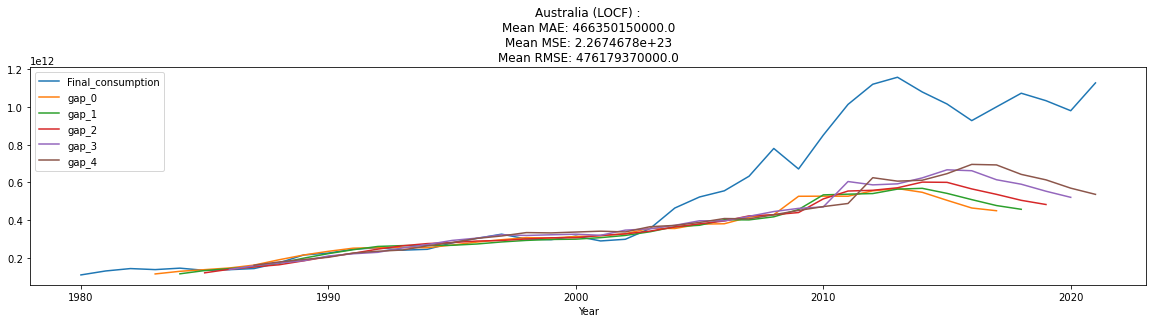

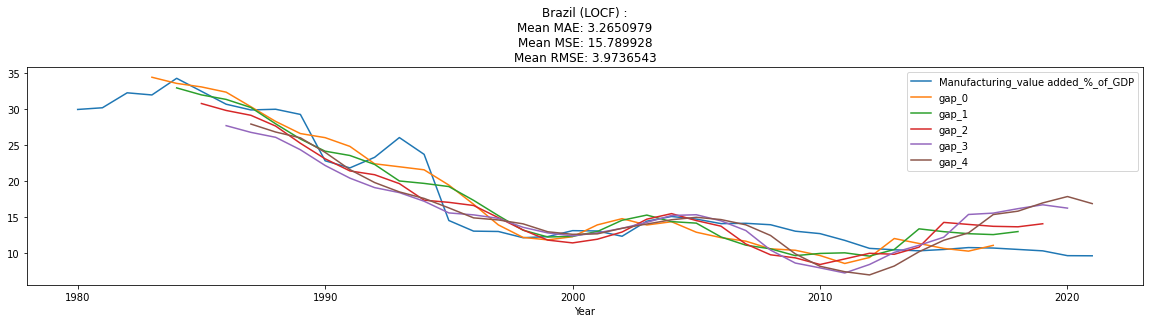

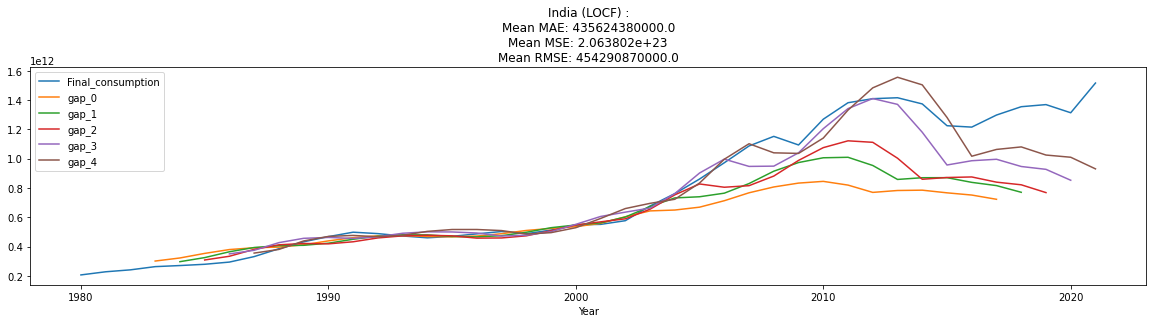

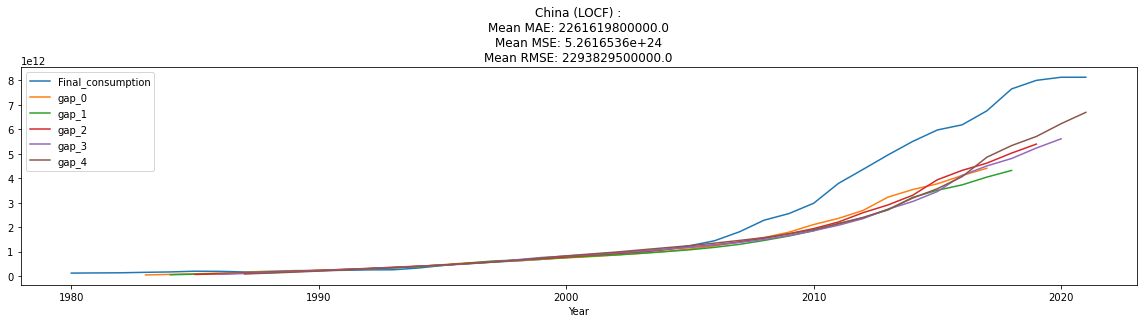

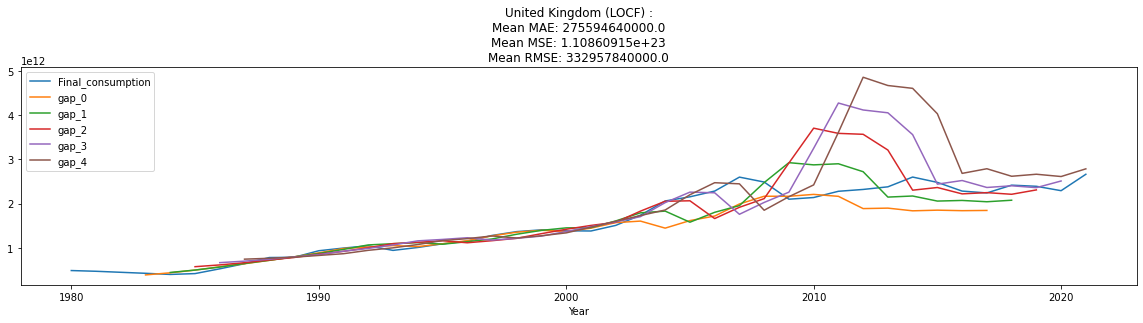

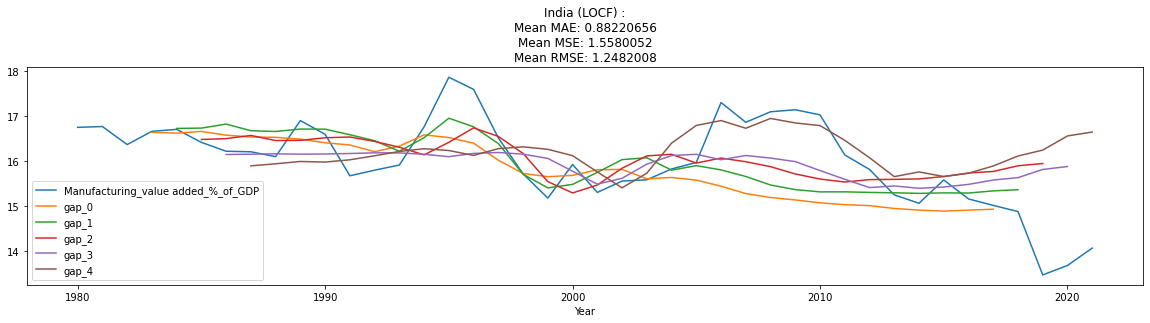

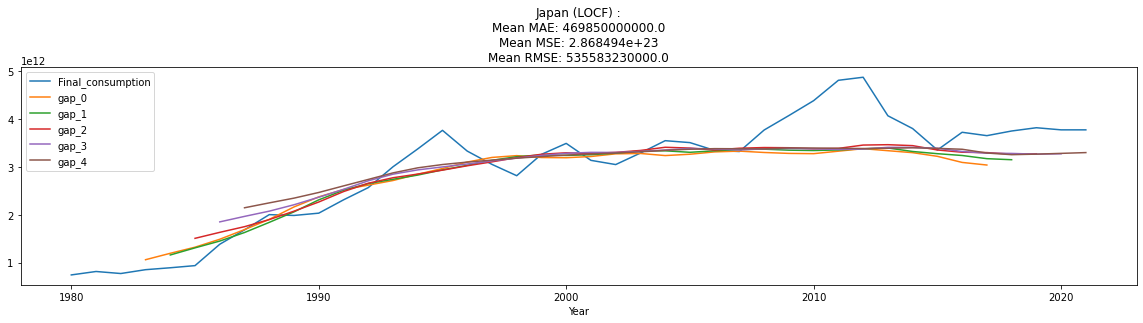

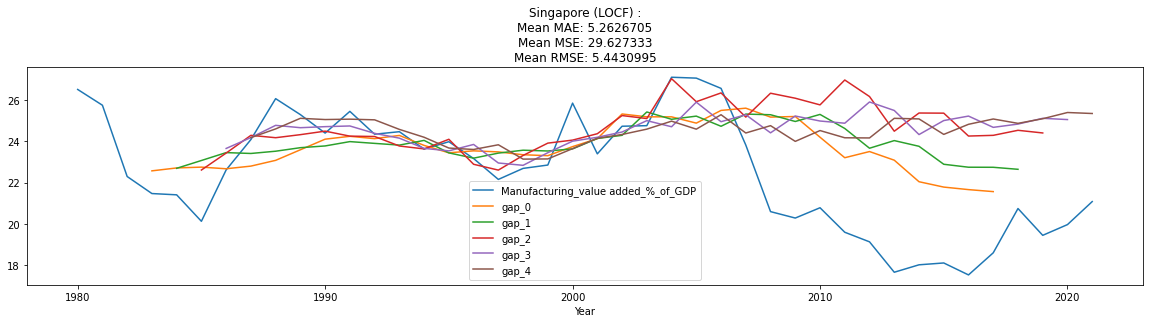

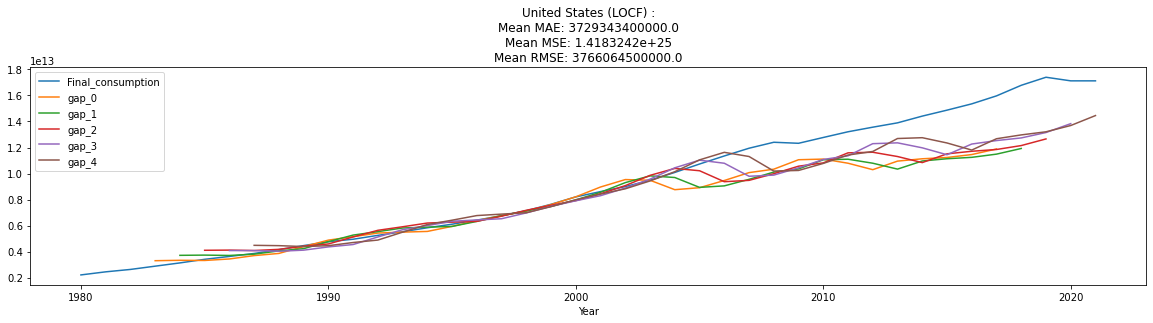

In [38]:
for sheet in get_sheet_by_methods(Data_dic_m, 2):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### NOCB

Australia NOCB :
Total Modelling Time:  9.644058227539062
MAE [9.899237, 9.413426, 9.32225, 12.849007, 13.54359]  Mean MAE 11.005502 
MSE [101.09173, 90.88918, 88.4718, 168.62442, 186.75603]  Mean MSE 127.166626 
RMSE [10.054439, 9.533582, 9.405945, 12.985546, 13.665871] Mean RMSE 11.276818


<AxesSubplot:title={'center':'Australia (NOCB) :\nMean MAE: 11.005502\nMean MSE: 127.166626\nMean RMSE: 11.276818'}, xlabel='Year'>

AUS_NOCB
2022  5.284519
2023  3.081598
2024  0.669259
2025 -2.054068
2026 -4.688046



Brazil NOCB :
Total Modelling Time:  9.516380071640015
MAE [7.8980966, 4.4949894, 0.40992832, 1.267752, 3.8557491]  Mean MAE 3.5853033 
MSE [63.565933, 20.544582, 0.18511851, 2.9263039, 18.491999]  Mean MSE 21.14279 
RMSE [7.9728246, 4.5326133, 0.430254, 1.7106442, 4.3002324] Mean RMSE 4.598129


<AxesSubplot:title={'center':'Brazil (NOCB) :\nMean MAE: 3.5853033\nMean MSE: 21.14279\nMean RMSE: 4.598129'}, xlabel='Year'>

BRA_NOCB
2022   6.455781
2023   7.812705
2024  10.425123
2025  10.757384
2026  12.026822



India NOCB :
Total Modelling Time:  10.074028015136719
MAE [368642980000.0, 248668900000.0, 185139120000.0, 111141430000.0, 114946890000.0]  Mean MAE 205707850000.0 
MSE [1.4404269e+23, 7.465381e+22, 5.013743e+22, 2.0413385e+22, 2.6093442e+22]  Mean MSE 6.3068152e+22 
RMSE [379529560000.0, 273228500000.0, 223913890000.0, 142875410000.0, 161534640000.0] Mean RMSE 251133740000.0


<AxesSubplot:title={'center':'India (NOCB) :\nMean MAE: 205707850000.0\nMean MSE: 6.3068152e+22\nMean RMSE: 251133740000.0'}, xlabel='Year'>

CAN_NOCB
2022  8.153412e+11
2023  8.250765e+11
2024  7.863528e+11
2025  8.046981e+11
2026  8.885003e+11



China NOCB :
Total Modelling Time:  9.572820901870728
MAE [2.360543, 2.9727876, 3.6237862, 4.318638, 4.604898]  Mean MAE 3.5761306 
MSE [7.3252487, 10.131262, 14.371562, 19.446665, 21.67597]  Mean MSE 14.590138 
RMSE [2.7065196, 3.1829643, 3.7909844, 4.4098372, 4.655746] Mean RMSE 3.819704


<AxesSubplot:title={'center':'China (NOCB) :\nMean MAE: 3.5761306\nMean MSE: 14.590138\nMean RMSE: 3.819704'}, xlabel='Year'>

CHN_NOCB
2022  31.990929
2023  31.984234
2024  31.984301
2025  32.002575
2026  32.049587



United Kingdom NOCB :
Total Modelling Time:  10.063108205795288
MAE [7.0467553, 6.9295974, 7.430494, 8.318628, 7.9361053]  Mean MAE 7.5323153 
MSE [54.153122, 51.408188, 58.427372, 73.35447, 66.35066]  Mean MSE 60.738766 
RMSE [7.3588805, 7.1699505, 7.6437798, 8.564722, 8.145592] Mean RMSE 7.793508


<AxesSubplot:title={'center':'United Kingdom (NOCB) :\nMean MAE: 7.5323153\nMean MSE: 60.738766\nMean RMSE: 7.793508'}, xlabel='Year'>

GBR_NOCB
2022  0.413257
2023  0.440498
2024 -0.246321
2025 -1.612471
2026 -1.315885



India NOCB :
Total Modelling Time:  9.255436658859253
MAE [1.4863948, 0.81431216, 0.41792965, 0.769231, 1.9942187]  Mean MAE 1.0964172 
MSE [2.2630923, 0.7154375, 0.50174063, 1.1487956, 4.733609]  Mean MSE 1.8725352 
RMSE [1.5043578, 0.8458354, 0.70833653, 1.0718188, 2.175686] Mean RMSE 1.368406


<AxesSubplot:title={'center':'India (NOCB) :\nMean MAE: 1.0964172\nMean MSE: 1.8725352\nMean RMSE: 1.368406'}, xlabel='Year'>

IND_NOCB
2022  13.459673
2023  14.161106
2024  15.081842
2025  15.533985
2026  17.127745



Japan NOCB :
Total Modelling Time:  9.958343267440796
MAE [5372.563, 3093.709, 3417.2266, 4360.153, 5813.293]  Mean MAE 4411.3887 
MSE [46649812.0, 13459189.0, 15282589.0, 23043784.0, 36961936.0]  Mean MSE 27079462.0 
RMSE [6830.067, 3668.6768, 3909.2952, 4800.394, 6079.633] Mean RMSE 5203.793


<AxesSubplot:title={'center':'Japan (NOCB) :\nMean MAE: 4411.3887\nMean MSE: 27079462.0\nMean RMSE: 5203.793'}, xlabel='Year'>

JPN_NOCB
2022  28625.628906
2023  30319.558594
2024  31500.130859
2025  32220.158203
2026  33562.289062



Singapore NOCB :
Total Modelling Time:  10.092142105102539
MAE [4.89621, 6.9399133, 7.920571, 7.5622125, 7.0331388]  Mean MAE 6.8704095 
MSE [24.261442, 49.40131, 63.514343, 57.84248, 50.136425]  Mean MSE 49.0312 
RMSE [4.9255905, 7.0286064, 7.9695888, 7.6054244, 7.080708] Mean RMSE 7.0022283


<AxesSubplot:title={'center':'Singapore (NOCB) :\nMean MAE: 6.8704095\nMean MSE: 49.0312\nMean RMSE: 7.0022283'}, xlabel='Year'>

SGP_NOCB
2022  20.141024
2023  23.105087
2024  25.752008
2025  27.043045
2026  27.761881



United States NOCB :
Total Modelling Time:  10.281015157699585
MAE [6047.225, 5927.5786, 5416.482, 4425.076, 3266.2812]  Mean MAE 5016.5283 
MSE [36858284.0, 35596936.0, 30378584.0, 23100806.0, 12629943.0]  Mean MSE 27712910.0 
RMSE [6071.1025, 5966.317, 5511.6772, 4806.3296, 3553.863] Mean RMSE 5264.305


<AxesSubplot:title={'center':'United States (NOCB) :\nMean MAE: 5016.5283\nMean MSE: 27712910.0\nMean RMSE: 5264.305'}, xlabel='Year'>

USA_NOCB
2022  64054.320312
2023  68414.671875
2024  72170.296875
2025  80044.781250
2026  85862.390625

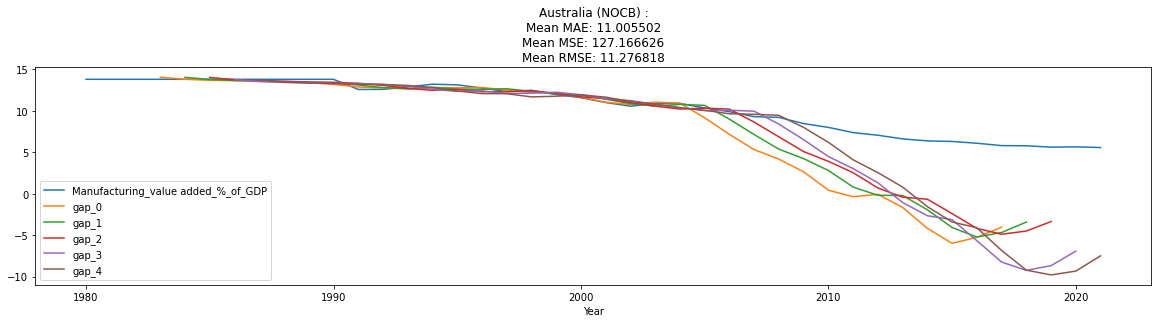

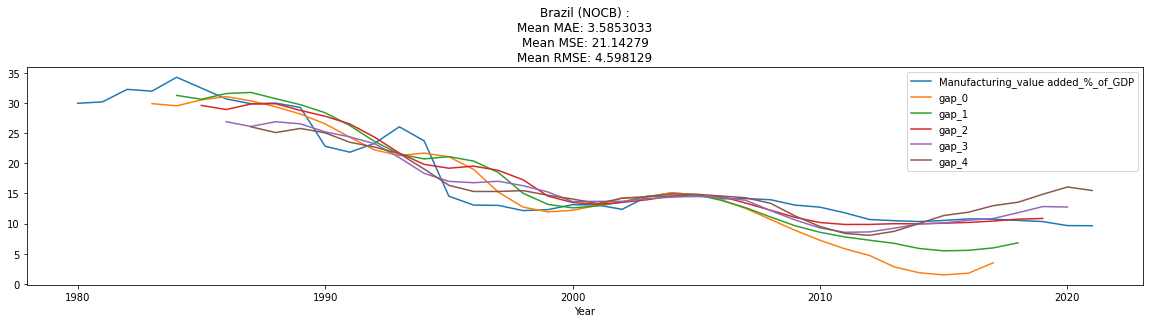

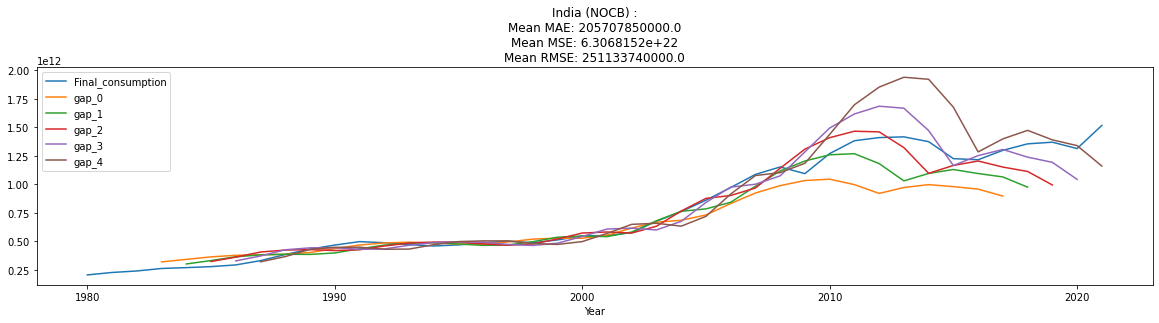

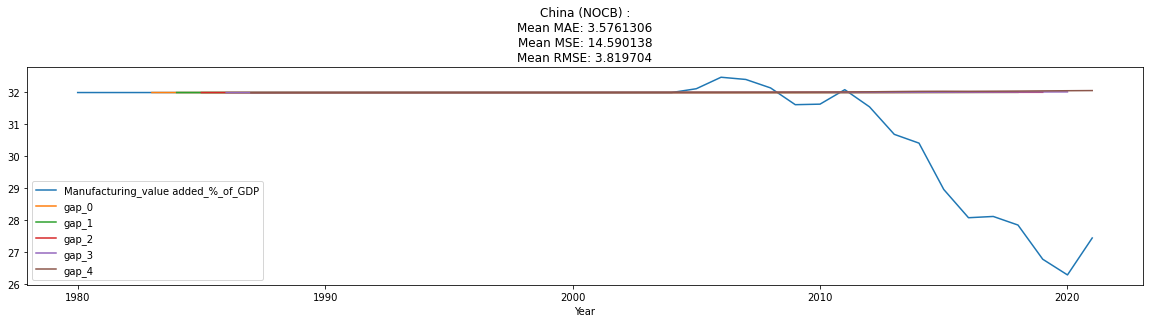

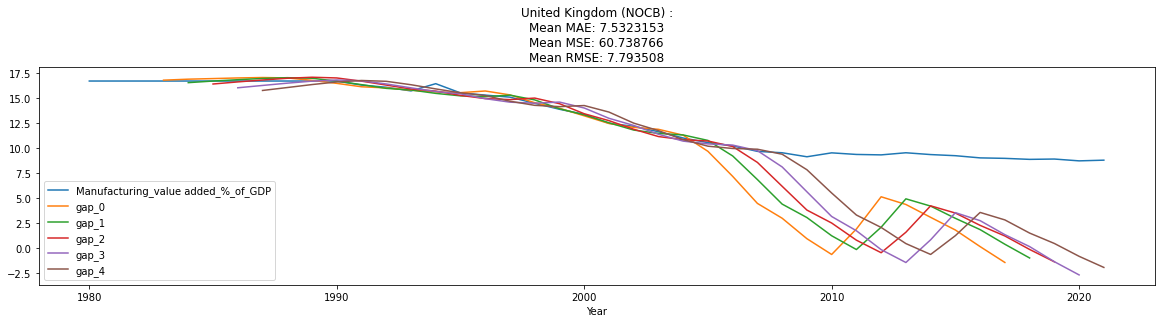

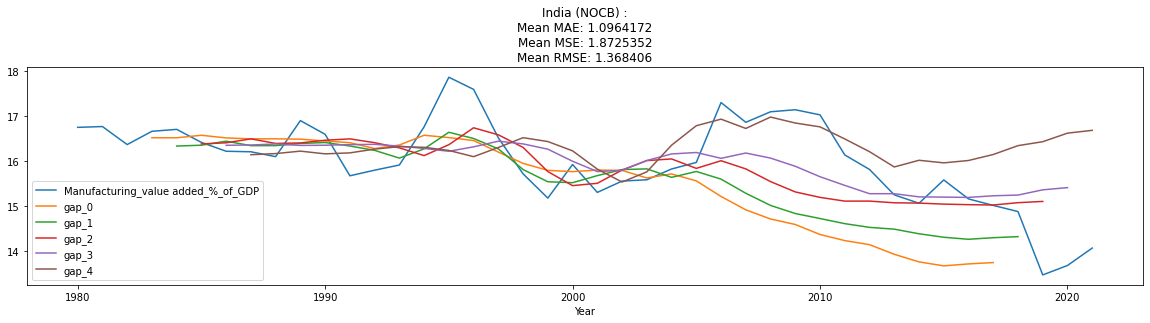

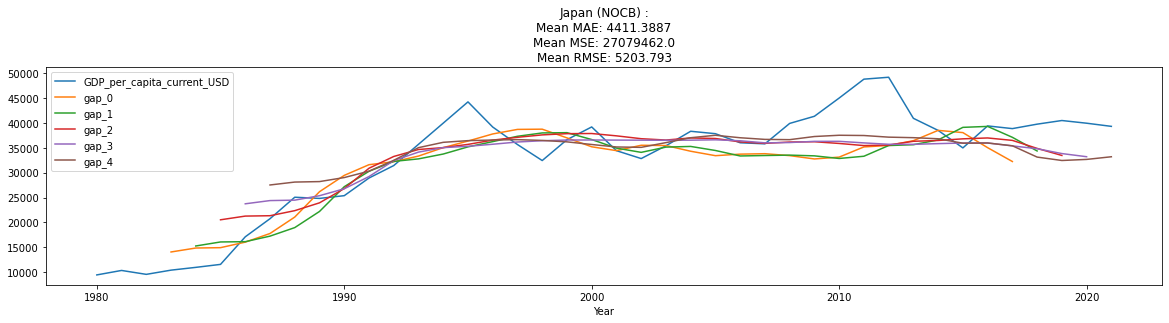

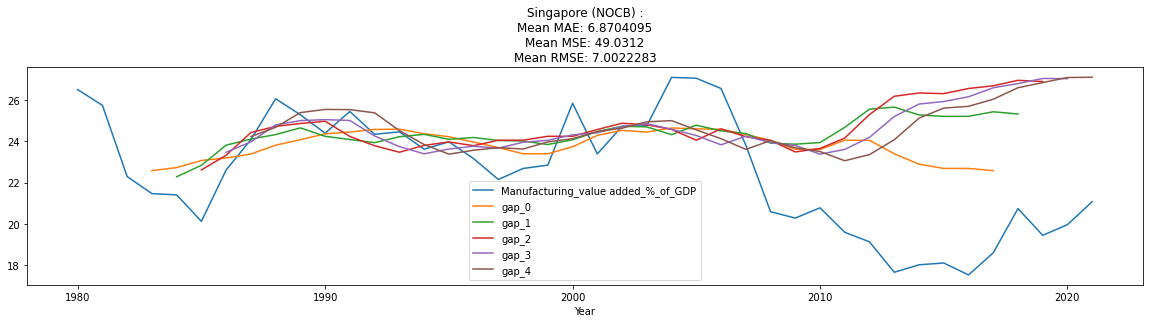

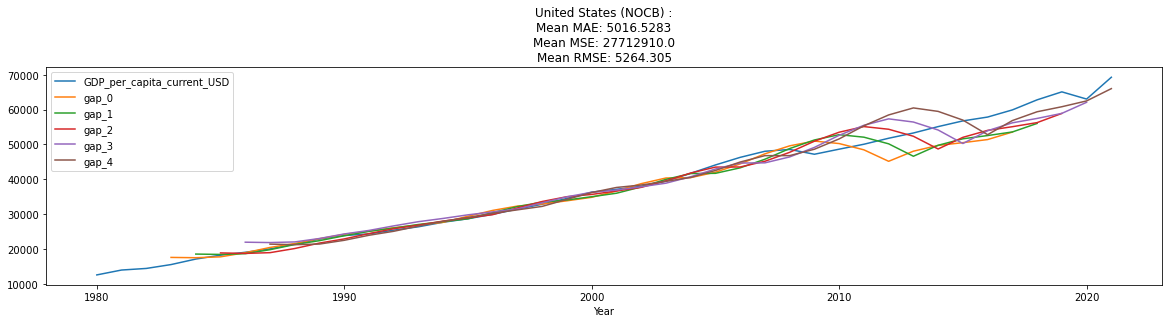

In [39]:
for sheet in get_sheet_by_methods(Data_dic_m, 3):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Rolling Stats

In [40]:
for sheet in get_sheet_by_methods(Data_dic_m, 4):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

Australia Rolling statistics :
Total Modelling Time:  10.01127028465271
MAE [365832830000.0, 380420880000.0, 385838840000.0, 364503900000.0, 357038720000.0]  Mean MAE 370727060000.0 
MSE [1.3577712e+23, 1.45531525e+23, 1.4944996e+23, 1.3317919e+23, 1.2785156e+23]  Mean MSE 1.3835788e+23 
RMSE [368479470000.0, 381485940000.0, 386587600000.0, 364937250000.0, 357563370000.0] Mean RMSE 371964870000.0
Cannot handle AUS, Rolling statistics
Brazil Rolling statistics :
Total Modelling Time:  10.035713195800781
MAE [2.0351975, 1.0661091, 0.58368176, 0.41043058, 0.78046733]  Mean MAE 0.9751772 
MSE [4.604304, 1.2043425, 0.34687623, 0.21847515, 0.9359565]  Mean MSE 1.461991 
RMSE [2.145764, 1.0974253, 0.588962, 0.46741325, 0.9674484] Mean RMSE 1.2091281
Cannot handle BRA, Rolling statistics
India Rolling statistics :
Total Modelling Time:  10.873790979385376
MAE [533058450000.0, 519169800000.0, 488789150000.0, 462106900000.0, 443212070000.0]  Mean MAE 489267230000.0 
MSE [2.8492034e+23, 2.7022482

###### Interpolate

In [41]:
for sheet in get_sheet_by_methods(Data_dic_m, 5):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

Australia Interpolate :
Cannot handle AUS, Interpolate
Brazil Interpolate :
Cannot handle BRA, Interpolate
India Interpolate :
Cannot handle CAN, Interpolate
China Interpolate :
Cannot handle CHN, Interpolate
United Kingdom Interpolate :
Cannot handle GBR, Interpolate
India Interpolate :
Cannot handle IND, Interpolate
Japan Interpolate :
Cannot handle JPN, Interpolate
Singapore Interpolate :
Cannot handle SGP, Interpolate
United States Interpolate :
Cannot handle USA, Interpolate


###### Summary

In [42]:
pd.DataFrame({
    'country': c,
    'method': m,
    'MAE': a,
    'MSE': s,
    'RMSE': r
})

country  method           MAE           MSE          RMSE
0      AUS    Mean  5.339529e+00  3.293368e+01  5.738787e+00
1      BRA    Mean  1.192884e+01  1.483349e+02  1.217928e+01
2      CAN    Mean  9.571383e-01  1.491263e+00  1.221173e+00
3      CHN    Mean  1.815056e+00  4.085854e+00  2.021349e+00
4      GBR    Mean  2.949953e+00  1.258728e+01  3.547856e+00
5      IND    Mean  1.237936e+00  2.471811e+00  1.572199e+00
6      JPN    Mean  1.131467e+00  1.587811e+00  1.260084e+00
7      SGP    Mean  3.153176e+00  1.150645e+01  3.392116e+00
8      USA    Mean  6.749746e-01  5.624734e-01  7.499823e-01
9      AUS  Median  5.162394e+00  3.013619e+01  5.489644e+00
10     BRA  Median  1.597622e+01  2.666135e+02  1.632830e+01
11     CAN  Median  1.876808e+00  4.091527e+00  2.022753e+00
12     CHN  Median  2.645944e+00  8.421987e+00  2.902066e+00
13     GBR  Median  2.121825e+00  1.058669e+01  3.253720e+00
14     IND  Median  1.122985e+00  1.895178e+00  1.376655e+00
15     JPN  Median  9.418995e-01  1.201613e+00  1.096181e+00
16     SGP  Median  3.726125e+00  1.543880e+01  3.929224e+00
17     USA  Median  4.897318e-01  4.667272e-01  6.831744e-01
18     AUS    LOCF  4.663501e+11  2.267468e+23  4.761794e+11
19     BRA    LOCF  3.265098e+00  1.578993e+01  3.973654e+00
20     CAN    LOCF  4.356244e+11  2.063802e+23  4.542909e+11
21     CHN    LOCF  2.261620e+12  5.261654e+24  2.293829e+12
22     GBR    LOCF  2.755946e+11  1.108609e+23  3.329578e+11
23     IND    LOCF  8.822066e-01  1.558005e+00  1.248201e+00
24     JPN    LOCF  4.698500e+11  2.868494e+23  5.355832e+11
25     SGP    LOCF  5.262671e+00  2.962733e+01  5.443099e+00
26     USA    LOCF  3.729343e+12  1.418324e+25  3.766065e+12
27     AUS    NOCB  1.100550e+01  1.271666e+02  1.127682e+01
28     BRA    NOCB  3.585303e+00  2.114279e+01  4.598129e+00
29     CAN    NOCB  2.057079e+11  6.306815e+22  2.511337e+11
30     CHN    NOCB  3.576131e+00  1.459014e+01  3.819704e+00
31     GBR    NOCB  7.532315e+00  6.073877e+01  7.793508e+00
32     IND    NOCB  1.096417e+00  1.872535e+00  1.368406e+00
33     JPN    NOCB  4.411389e+03  2.707946e+07  5.203793e+03
34     SGP    NOCB  6.870409e+00  4.903120e+01  7.002228e+00
35     USA    NOCB  5.016528e+03  2.771291e+07  5.264305e+03

##### Service

In [43]:
c, m, a, s, r = [], [], [], [], []

###### Mean

Australia Mean :
Total Modelling Time:  11.283507823944092
MAE [3.8320916, 4.5704436, 5.161033, 5.471445, 5.5480638]  Mean MAE 4.916616 
MSE [14.977211, 22.220695, 29.426977, 34.508663, 35.402134]  Mean MSE 27.307135 
RMSE [3.8700402, 4.7138834, 5.424664, 5.8744073, 5.9499693] Mean RMSE 5.225623


<AxesSubplot:title={'center':'Australia (Mean) :\nMean MAE: 4.916616\nMean MSE: 27.307135\nMean RMSE: 5.225623'}, xlabel='Year'>

AUS_Mean
2022  3.316080
2023  2.810784
2024  1.397556
2025  1.671823
2026  3.027111



Brazil Mean :
Total Modelling Time:  11.574385166168213
MAE [18.10083, 17.293184, 15.000274, 14.423492, 13.06474]  Mean MAE 15.576505 
MSE [329.44922, 301.81192, 227.4651, 210.19763, 172.64348]  Mean MSE 248.31348 
RMSE [18.150736, 17.372734, 15.081946, 14.498194, 13.139386] Mean RMSE 15.757965


<AxesSubplot:title={'center':'Brazil (Mean) :\nMean MAE: 15.576505\nMean MSE: 248.31348\nMean RMSE: 15.757965'}, xlabel='Year'>

BRA_Mean
2022   8.218956
2023   8.962729
2024  10.234810
2025  11.910696
2026  12.341925



India Mean :
Total Modelling Time:  11.249192953109741
MAE [1.2597654, 0.8309534, 0.5561001, 0.94038486, 1.7118219]  Mean MAE 1.0598052 
MSE [2.0125105, 0.9955086, 0.43194786, 1.1012639, 4.061901]  Mean MSE 1.7206265 
RMSE [1.4186298, 0.9977518, 0.6572274, 1.0494112, 2.015416] Mean RMSE 1.3117266


<AxesSubplot:title={'center':'India (Mean) :\nMean MAE: 1.0598052\nMean MSE: 1.7206265\nMean RMSE: 1.3117266'}, xlabel='Year'>

CAN_Mean
2022  13.212416
2023  14.893553
2024  18.625891
2025  19.405220
2026  20.655556



China Mean :
Total Modelling Time:  11.635130882263184
MAE [1.2042376, 1.2842264, 1.663888, 2.2955017, 2.4881818]  Mean MAE 1.7872071 
MSE [1.8861909, 2.2422175, 3.5555484, 5.69898, 6.426014]  Mean MSE 3.9617903 
RMSE [1.3733866, 1.4974036, 1.8856162, 2.3872535, 2.5349584] Mean RMSE 1.9904246


<AxesSubplot:title={'center':'China (Mean) :\nMean MAE: 1.7872071\nMean MSE: 3.9617903\nMean RMSE: 1.9904246'}, xlabel='Year'>

CHN_Mean
2022  30.026184
2023  29.901541
2024  29.542974
2025  29.467274
2026  29.146860



United Kingdom Mean :
Total Modelling Time:  11.351042032241821
MAE [2.583477, 2.6494863, 3.107008, 3.3744, 3.5788727]  Mean MAE 3.0586488 
MSE [11.182275, 11.499057, 14.158015, 15.902219, 17.423399]  Mean MSE 14.032993 
RMSE [3.3439908, 3.391026, 3.762714, 3.9877586, 4.1741347] Mean RMSE 3.7460637


<AxesSubplot:title={'center':'United Kingdom (Mean) :\nMean MAE: 3.0586488\nMean MSE: 14.032993\nMean RMSE: 3.7460637'}, xlabel='Year'>

GBR_Mean
2022  13.361707
2023  13.253611
2024  13.262223
2025  13.363825
2026  13.359292



India Mean :
Total Modelling Time:  11.556186199188232
MAE [0.6063482, 0.6998641, 1.3285313, 1.4989353, 1.9445268]  Mean MAE 1.2156411 
MSE [0.50953054, 0.617466, 2.7455094, 3.5869274, 4.744357]  Mean MSE 2.440758 
RMSE [0.7138141, 0.78579, 1.6569579, 1.8939185, 2.1781545] Mean RMSE 1.5622926


<AxesSubplot:title={'center':'India (Mean) :\nMean MAE: 1.2156411\nMean MSE: 2.440758\nMean RMSE: 1.5622926'}, xlabel='Year'>

IND_Mean
2022  16.150896
2023  16.172165
2024  15.739243
2025  15.475780
2026  15.418430



Japan Mean :
Total Modelling Time:  11.775625944137573
MAE [0.9775035, 1.1753836, 1.0558923, 1.001412, 1.0780725]  Mean MAE 1.0576528 
MSE [1.3494328, 1.7696586, 1.5543284, 1.1503798, 1.2539098]  Mean MSE 1.4155418 
RMSE [1.1616509, 1.3302852, 1.2467271, 1.0725576, 1.1197811] Mean RMSE 1.1897655


<AxesSubplot:title={'center':'Japan (Mean) :\nMean MAE: 1.0576528\nMean MSE: 1.4155418\nMean RMSE: 1.1897655'}, xlabel='Year'>

JPN_Mean
2022  20.994537
2023  20.261610
2024  19.508282
2025  19.220110
2026  19.400208



Singapore Mean :
Total Modelling Time:  11.390899419784546
MAE [3.9173365, 3.4108553, 2.9948175, 2.7848272, 2.45524]  Mean MAE 3.112615 
MSE [15.596116, 13.662568, 10.778209, 9.346287, 7.172407]  Mean MSE 11.311118 
RMSE [3.9491918, 3.6962912, 3.2830184, 3.0571697, 2.678135] Mean RMSE 3.3632007


<AxesSubplot:title={'center':'Singapore (Mean) :\nMean MAE: 3.112615\nMean MSE: 11.311118\nMean RMSE: 3.3632007'}, xlabel='Year'>

SGP_Mean
2022  20.488001
2023  20.352610
2024  20.568308
2025  21.173223
2026  22.742701



United States Mean :
Total Modelling Time:  11.719658136367798
MAE [0.55902416, 0.87873745, 0.5535138, 0.32611737, 0.6625045]  Mean MAE 0.5959795 
MSE [0.3268021, 0.7876008, 0.34150016, 0.12831925, 0.5854191]  Mean MSE 0.43392834 
RMSE [0.57166606, 0.88746876, 0.58438015, 0.35821676, 0.7651269] Mean RMSE 0.65873235


<AxesSubplot:title={'center':'United States (Mean) :\nMean MAE: 0.5959795\nMean MSE: 0.43392834\nMean RMSE: 0.65873235'}, xlabel='Year'>

USA_Mean
2022  12.053701
2023  12.792202
2024  14.924351
2025  16.294153
2026  16.113907

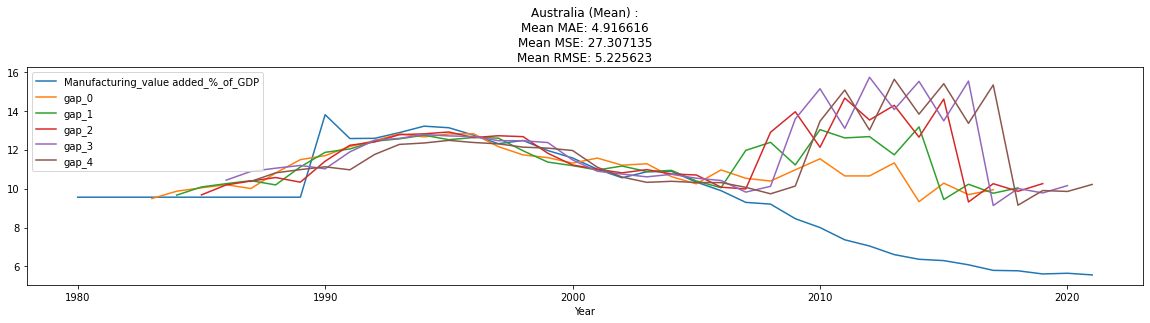

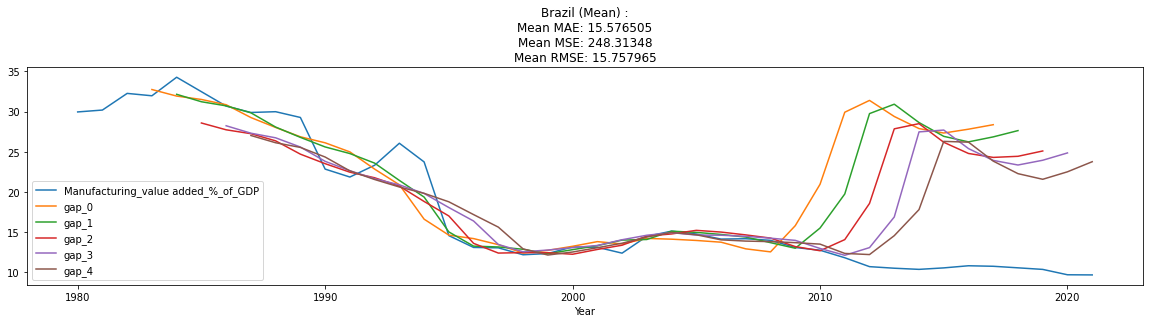

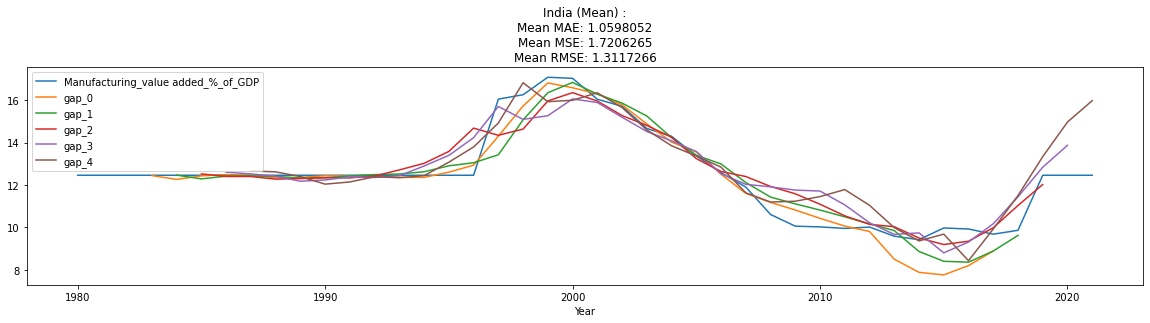

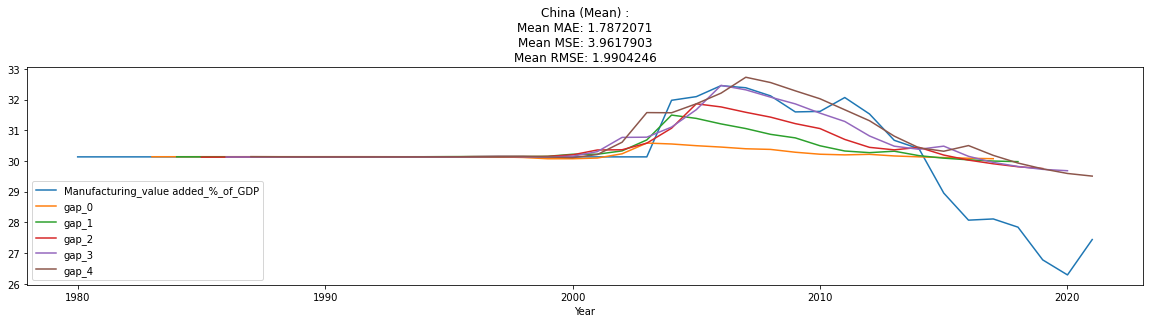

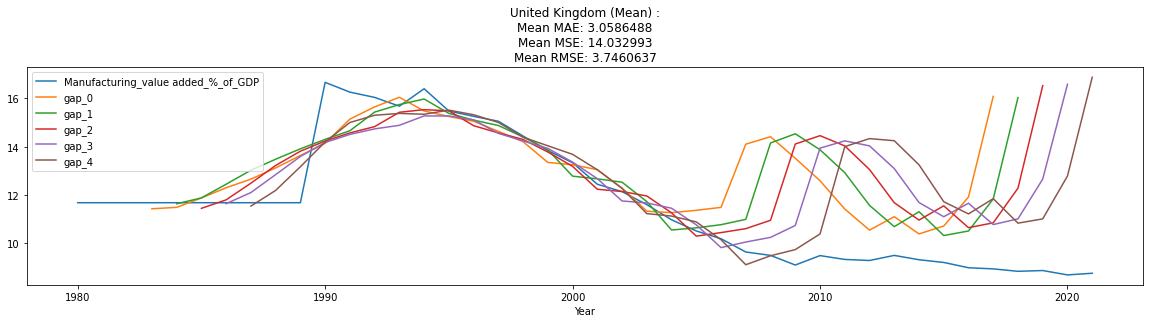

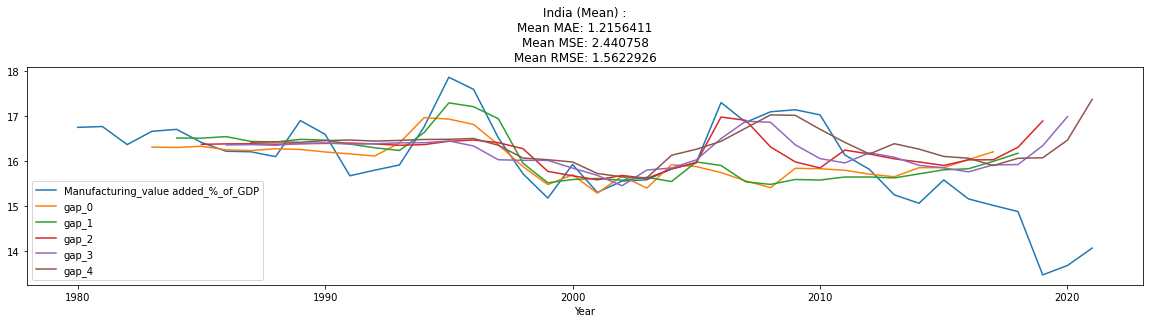

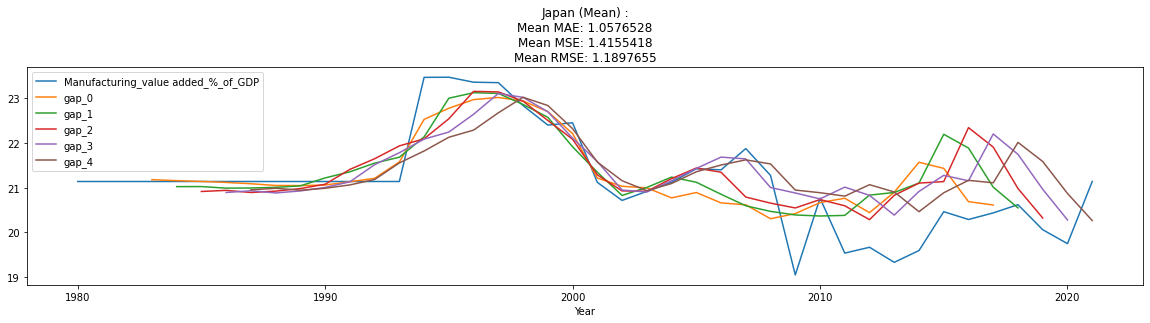

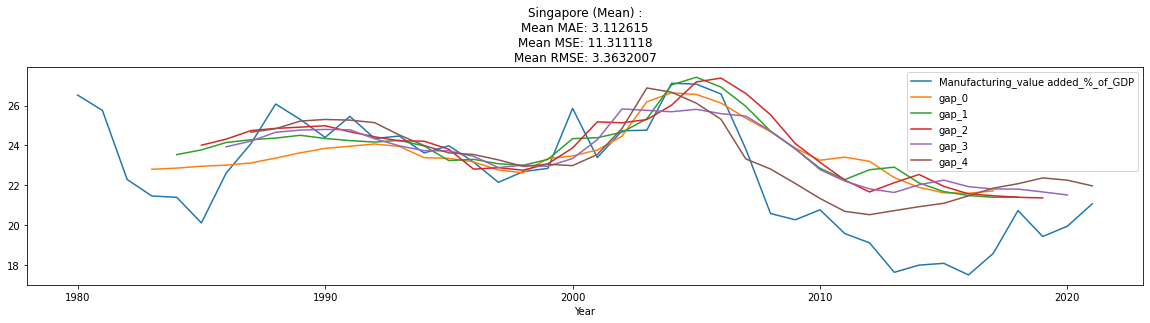

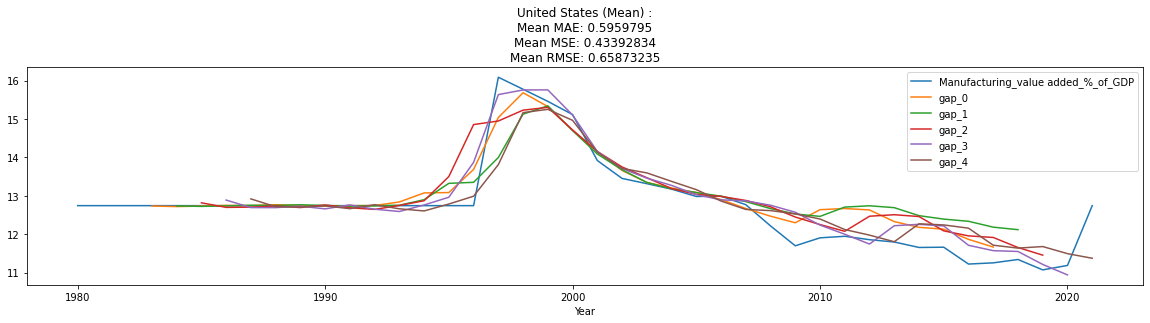

In [44]:
for sheet in get_sheet_by_methods(Data_dic_s, 0):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### Median

Australia Median :
Total Modelling Time:  10.86025595664978
MAE [3.7551043, 4.5858274, 4.9514346, 5.513714, 5.673264]  Mean MAE 4.8958693 
MSE [14.592893, 22.779993, 26.79039, 34.625988, 36.36108]  Mean MSE 27.03007 
RMSE [3.8200645, 4.772839, 5.1759434, 5.884385, 6.030015] Mean RMSE 5.199045


<AxesSubplot:title={'center':'Australia (Median) :\nMean MAE: 4.8958693\nMean MSE: 27.03007\nMean RMSE: 5.199045'}, xlabel='Year'>

AUS_Median
2022    9.699994
2023    9.559985
2024    9.423992
2025    9.404593
2026    9.602865



Brazil Median :
Total Modelling Time:  10.991611957550049
MAE [13.787354, 9.37878, 9.59016, 9.114064, 8.6602125]  Mean MAE 10.106113 
MSE [194.57056, 95.30347, 98.433235, 86.797615, 77.75086]  Mean MSE 110.571144 
RMSE [13.948855, 9.762349, 9.921352, 9.316524, 8.817645] Mean RMSE 10.515282


<AxesSubplot:title={'center':'Brazil (Median) :\nMean MAE: 10.106113\nMean MSE: 110.571144\nMean RMSE: 10.515282'}, xlabel='Year'>

BRA_Median
2022    6.756173
2023    7.959783
2024    8.932449
2025   10.537242
2026   11.912818



India Median :
Total Modelling Time:  11.592315912246704
MAE [2.265713, 1.894009, 1.7534481, 2.0475636, 1.5845548]  Mean MAE 1.9090577 
MSE [5.593235, 4.2004113, 3.6009567, 4.981111, 3.04667]  Mean MSE 4.2844768 
RMSE [2.3650022, 2.0494905, 1.8976187, 2.2318404, 1.7454712] Mean RMSE 2.0698977


<AxesSubplot:title={'center':'India (Median) :\nMean MAE: 1.9090577\nMean MSE: 4.2844768\nMean RMSE: 2.0698977'}, xlabel='Year'>

CAN_Median
2022   13.875185
2023   16.282864
2024   17.743950
2025   18.987812
2026   18.693445



China Median :
Total Modelling Time:  11.673826932907104
MAE [1.5879847, 2.0644462, 2.6866534, 3.3409302, 3.578534]  Mean MAE 2.65171 
MSE [3.7955084, 5.425409, 8.198166, 11.723541, 13.124377]  Mean MSE 8.453401 
RMSE [1.9482064, 2.3292508, 2.863244, 3.4239657, 3.6227582] Mean RMSE 2.9074733


<AxesSubplot:title={'center':'China (Median) :\nMean MAE: 2.65171\nMean MSE: 8.453401\nMean RMSE: 2.9074733'}, xlabel='Year'>

CHN_Median
2022   31.014761
2023   30.959188
2024   30.806150
2025   30.708288
2026   30.614315



United Kingdom Median :
Total Modelling Time:  11.758433103561401
MAE [1.4071623, 1.6612186, 1.9169064, 2.207352, 2.2350543]  Mean MAE 1.8855385 
MSE [5.253802, 6.6883883, 8.783768, 10.561629, 9.288842]  Mean MSE 8.115286 
RMSE [2.2921174, 2.586192, 2.9637423, 3.249866, 3.0477602] Mean RMSE 2.8487341


<AxesSubplot:title={'center':'United Kingdom (Median) :\nMean MAE: 1.8855385\nMean MSE: 8.115286\nMean RMSE: 2.8487341'}, xlabel='Year'>

GBR_Median
2022   11.772297
2023   11.677980
2024   11.783805
2025   12.065622
2026   11.756979



India Median :
Total Modelling Time:  11.565077066421509
MAE [0.48388147, 0.61677235, 1.3193951, 1.3433155, 1.7622333]  Mean MAE 1.1051196 
MSE [0.29999986, 0.4267707, 2.3140454, 2.6107678, 3.621545]  Mean MSE 1.8546258 
RMSE [0.54772246, 0.65327686, 1.5211986, 1.615787, 1.9030358] Mean RMSE 1.3618464


<AxesSubplot:title={'center':'India (Median) :\nMean MAE: 1.1051196\nMean MSE: 1.8546258\nMean RMSE: 1.3618464'}, xlabel='Year'>

IND_Median
2022   15.960606
2023   16.092916
2024   15.664913
2025   15.427012
2026   15.321482



Japan Median :
Total Modelling Time:  11.793637990951538
MAE [0.99308234, 1.2016464, 1.0039402, 1.0027958, 1.0599838]  Mean MAE 1.0522897 
MSE [1.432546, 1.7816263, 1.3900247, 1.1659356, 1.1979703]  Mean MSE 1.3936206 
RMSE [1.1968901, 1.3347758, 1.1789931, 1.079785, 1.0945183] Mean RMSE 1.1805171


<AxesSubplot:title={'center':'Japan (Median) :\nMean MAE: 1.0522897\nMean MSE: 1.3936206\nMean RMSE: 1.1805171'}, xlabel='Year'>

JPN_Median
2022   20.124073
2023   19.697372
2024   19.684488
2025   19.275885
2026   19.375170



Singapore Median :
Total Modelling Time:  11.88715386390686
MAE [4.3635125, 3.9114263, 4.0731463, 3.2992327, 2.6864727]  Mean MAE 3.6667583 
MSE [19.230864, 17.006392, 18.150597, 12.422863, 8.355535]  Mean MSE 15.033251 
RMSE [4.3853006, 4.123881, 4.2603517, 3.5246081, 2.8905942] Mean RMSE 3.8772736


<AxesSubplot:title={'center':'Singapore (Median) :\nMean MAE: 3.6667583\nMean MSE: 15.033251\nMean RMSE: 3.8772736'}, xlabel='Year'>

SGP_Median
2022   21.307106
2023   20.987928
2024   21.831293
2025   21.618502
2026   22.984331



United States Median :
Total Modelling Time:  12.257838010787964
MAE [0.19535907, 0.20447493, 0.35888147, 0.6975177, 1.0126582]  Mean MAE 0.4937783 
MSE [0.0527909, 0.06734774, 0.15624253, 0.63149816, 1.5022699]  Mean MSE 0.48202986 
RMSE [0.2297627, 0.25951445, 0.39527526, 0.79466856, 1.2256712] Mean RMSE 0.6942837


<AxesSubplot:title={'center':'United States (Median) :\nMean MAE: 0.4937783\nMean MSE: 0.48202986\nMean RMSE: 0.6942837'}, xlabel='Year'>

USA_Median
2022   10.977369
2023   11.357551
2024   12.642606
2025   13.578305
2026   14.249475

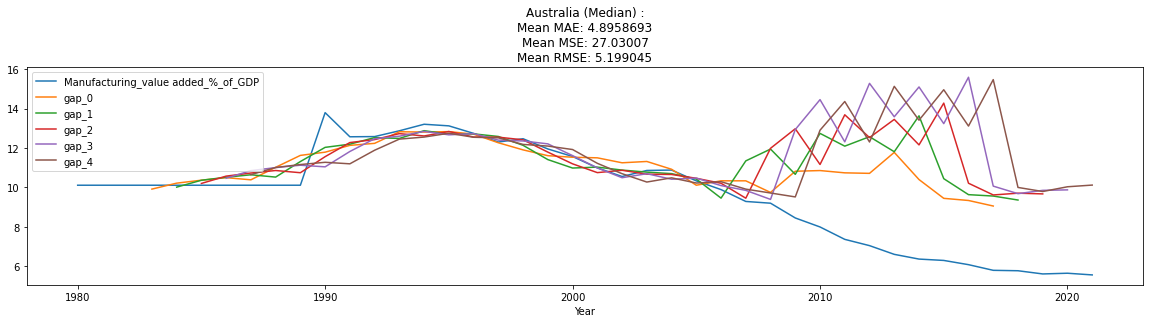

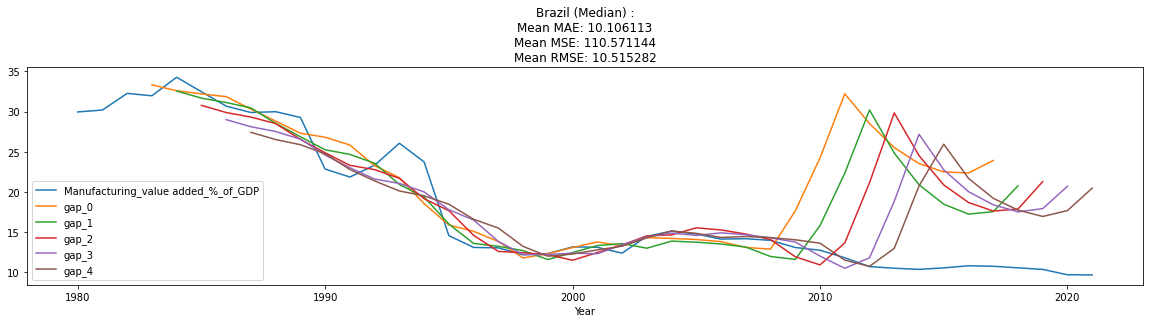

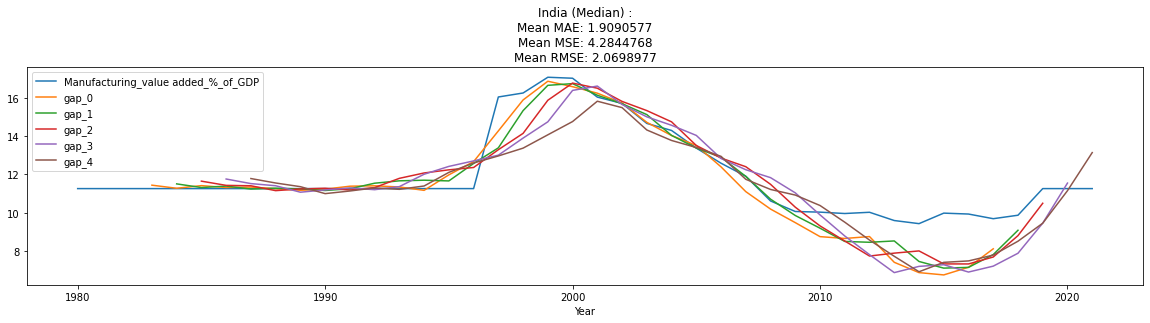

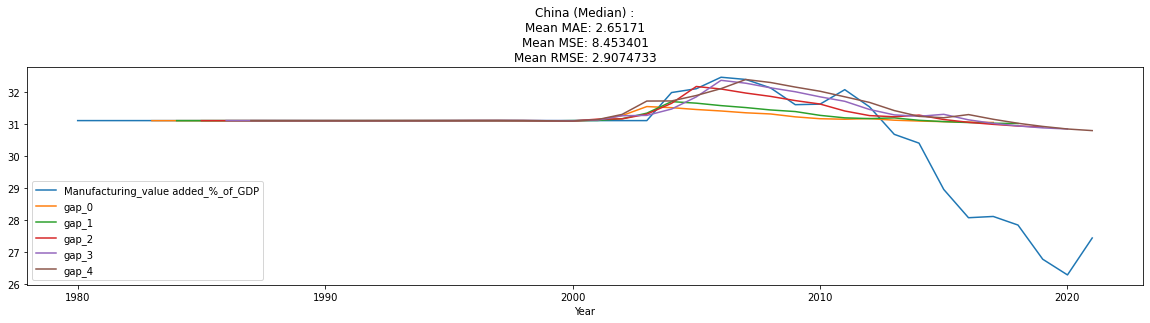

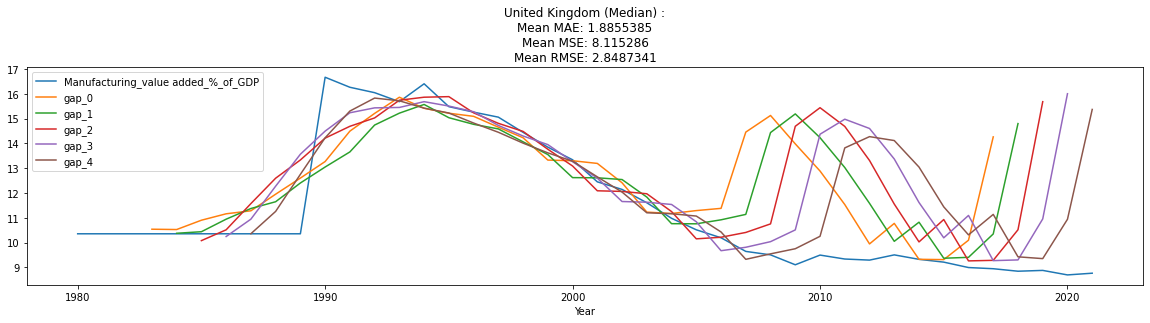

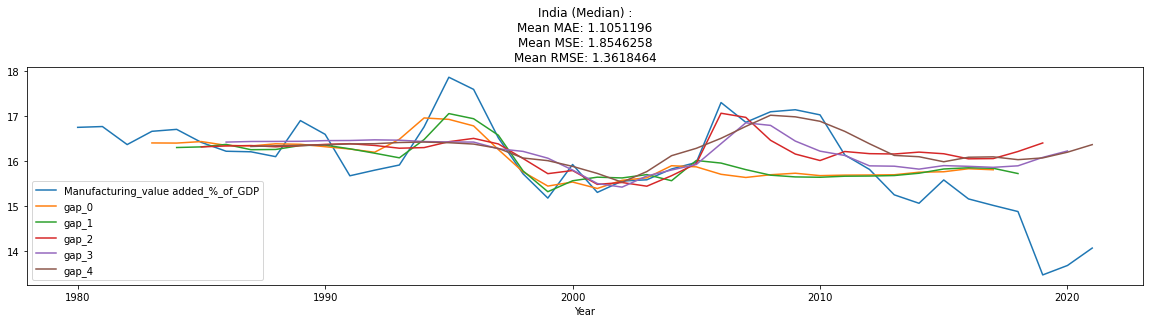

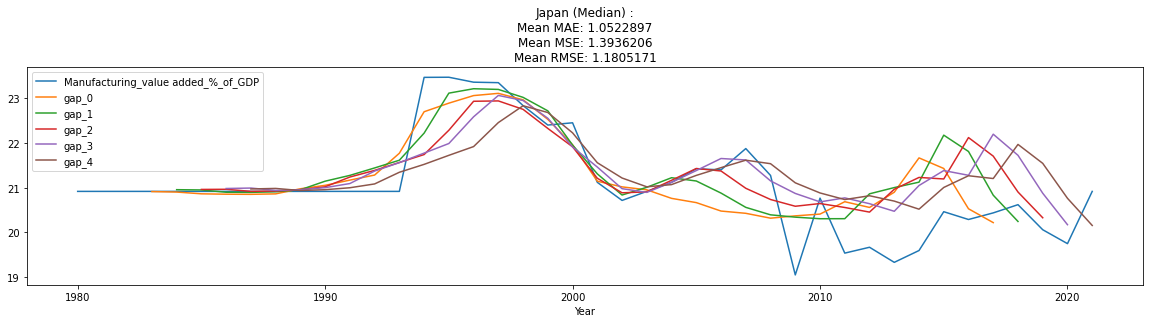

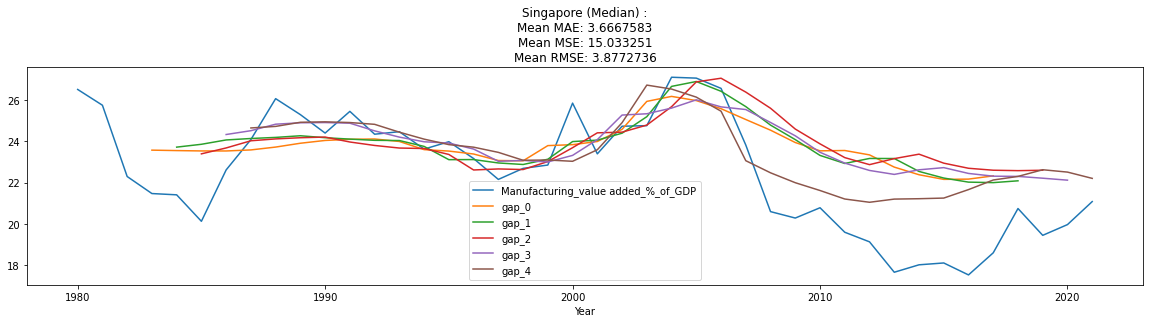

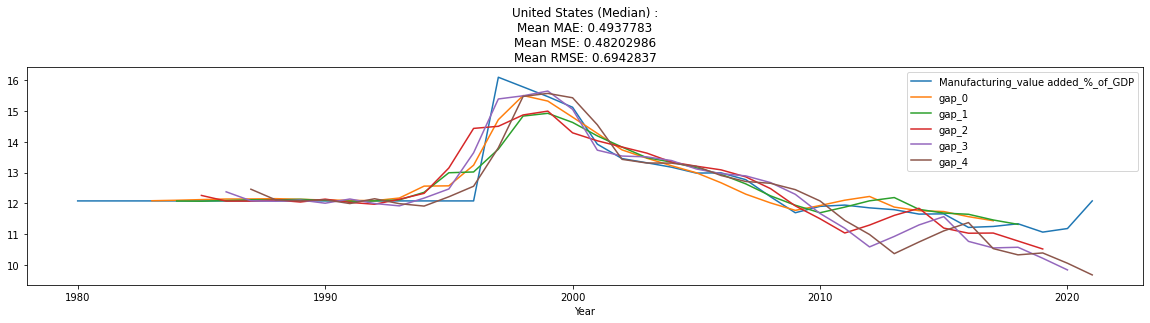

In [45]:
for sheet in get_sheet_by_methods(Data_dic_s, 1):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### LOCF

Australia LOCF :
Total Modelling Time:  12.083747148513794
MAE [493349670000.0, 480240760000.0, 426105000000.0, 348775550000.0, 324542630000.0]  Mean MAE 414602720000.0 
MSE [2.4516429e+23, 2.3496057e+23, 1.8586914e+23, 1.2672323e+23, 1.1700549e+23]  Mean MSE 1.8194454e+23 
RMSE [495140670000.0, 484727320000.0, 431125430000.0, 355982080000.0, 342060660000.0] Mean RMSE 426549580000.0


<AxesSubplot:title={'center':'Australia (LOCF) :\nMean MAE: 414602720000.0\nMean MSE: 1.8194454e+23\nMean RMSE: 426549580000.0'}, xlabel='Year'>

AUS_LOCF
2022  3.509226e+11
2023  3.449460e+11
2024  3.856424e+11
2025  4.493989e+11
2026  4.701461e+11



Brazil LOCF :
Total Modelling Time:  12.073607921600342
MAE [0.80571145, 1.8786324, 3.3214438, 5.313798, 6.2105637]  Mean MAE 3.50603 
MSE [0.89869905, 4.358804, 12.342851, 31.791334, 42.70811]  Mean MSE 18.419958 
RMSE [0.9479974, 2.087775, 3.5132394, 5.6383805, 6.5351443] Mean RMSE 4.2918477


<AxesSubplot:title={'center':'Brazil (LOCF) :\nMean MAE: 3.50603\nMean MSE: 18.419958\nMean RMSE: 4.2918477'}, xlabel='Year'>

BRA_LOCF
2022  10.905323
2023  11.413828
2024  11.819770
2025  11.570934
2026  12.066893



India LOCF :
Total Modelling Time:  12.33019208908081
MAE [547360740000.0, 474997330000.0, 490158400000.0, 355700340000.0, 317712070000.0]  Mean MAE 437185770000.0 
MSE [3.059532e+23, 2.3308836e+23, 2.4786957e+23, 1.3368222e+23, 1.1554594e+23]  Mean MSE 2.0722788e+23 
RMSE [553130300000.0, 482792240000.0, 497865000000.0, 365625800000.0, 339920500000.0] Mean RMSE 455222900000.0


<AxesSubplot:title={'center':'India (LOCF) :\nMean MAE: 437185770000.0\nMean MSE: 2.0722788e+23\nMean RMSE: 455222900000.0'}, xlabel='Year'>

CAN_LOCF
2022  6.706763e+11
2023  6.304061e+11
2024  5.893561e+11
2025  6.243692e+11
2026  7.158192e+11



China LOCF :
Total Modelling Time:  11.893501043319702
MAE [1970260800000.0, 2285239000000.0, 2331973500000.0, 2101892600000.0, 1752959700000.0]  Mean MAE 2088465000000.0 
MSE [3.9318393e+24, 5.302848e+24, 5.5249855e+24, 4.4789525e+24, 3.1850532e+24]  Mean MSE 4.4847358e+24 
RMSE [1982886600000.0, 2302791400000.0, 2350528900000.0, 2116353500000.0, 1784671800000.0] Mean RMSE 2117719400000.0


<AxesSubplot:title={'center':'China (LOCF) :\nMean MAE: 2088465000000.0\nMean MSE: 4.4847358e+24\nMean RMSE: 2117719400000.0'}, xlabel='Year'>

CHN_LOCF
2022  5.804497e+12
2023  6.208947e+12
2024  6.778447e+12
2025  7.962898e+12
2026  9.130969e+12



United Kingdom LOCF :
Total Modelling Time:  11.662372827529907
MAE [563472000000.0, 396872650000.0, 252341850000.0, 106035320000.0, 163899980000.0]  Mean MAE 296524350000.0 
MSE [3.350087e+23, 1.6736169e+23, 7.321133e+22, 1.3242744e+22, 3.920057e+22]  Mean MSE 1.25605e+23 
RMSE [578799340000.0, 409098620000.0, 270575930000.0, 115077120000.0, 197991330000.0] Mean RMSE 354407940000.0


<AxesSubplot:title={'center':'United Kingdom (LOCF) :\nMean MAE: 296524350000.0\nMean MSE: 1.25605e+23\nMean RMSE: 354407940000.0'}, xlabel='Year'>

GBR_LOCF
2022  1.369318e+12
2023  1.403210e+12
2024  1.454869e+12
2025  1.638586e+12
2026  1.793542e+12



India LOCF :
Total Modelling Time:  11.672711849212646
MAE [0.61509466, 0.21070082, 0.8814268, 1.092378, 2.1080534]  Mean MAE 0.9815307 
MSE [0.44930157, 0.06602776, 1.3497562, 1.983167, 5.2439938]  Mean MSE 1.8184494 
RMSE [0.6702996, 0.25695866, 1.1617901, 1.4082496, 2.2899768] Mean RMSE 1.348499


<AxesSubplot:title={'center':'India (LOCF) :\nMean MAE: 0.9815307\nMean MSE: 1.8184494\nMean RMSE: 1.348499'}, xlabel='Year'>

IND_LOCF
2022  14.634967
2023  15.377872
2024  16.168856
2025  16.125036
2026  17.434689



Japan LOCF :
Total Modelling Time:  11.836899042129517
MAE [642640500000.0, 428728400000.0, 353612760000.0, 368213260000.0, 439302130000.0]  Mean MAE 446499450000.0 
MSE [5.7900828e+23, 2.1804585e+23, 1.5374999e+23, 1.5867471e+23, 1.9815937e+23]  Mean MSE 2.6152762e+23 
RMSE [760925900000.0, 466953800000.0, 392109650000.0, 398339930000.0, 445150950000.0] Mean RMSE 511397700000.0


<AxesSubplot:title={'center':'Japan (LOCF) :\nMean MAE: 446499450000.0\nMean MSE: 2.6152762e+23\nMean RMSE: 511397700000.0'}, xlabel='Year'>

JPN_LOCF
2022  3.019186e+12
2023  3.199791e+12
2024  3.364940e+12
2025  3.311395e+12
2026  3.291418e+12



Singapore LOCF :
Total Modelling Time:  12.548918008804321
MAE [3.3987253, 4.343773, 5.3166547, 5.886812, 6.1850257]  Mean MAE 5.026198 
MSE [12.207358, 21.360697, 30.148819, 36.15784, 39.4375]  Mean MSE 27.86244 
RMSE [3.493903, 4.621763, 5.490794, 6.013139, 6.279928] Mean RMSE 5.2784886


<AxesSubplot:title={'center':'Singapore (LOCF) :\nMean MAE: 5.026198\nMean MSE: 27.86244\nMean RMSE: 5.2784886'}, xlabel='Year'>

SGP_LOCF
2022  18.623741
2023  20.098597
2024  21.833605
2025  24.149050
2026  26.068773



United States LOCF :
Total Modelling Time:  12.012809038162231
MAE [3730209200000.0, 3826342700000.0, 4179907000000.0, 3412709900000.0, 3326175300000.0]  Mean MAE 3695069000000.0 
MSE [1.4093234e+25, 1.4859098e+25, 1.77547e+25, 1.1808845e+25, 1.1309573e+25]  Mean MSE 1.396509e+25 
RMSE [3754095500000.0, 3854750000000.0, 4213632700000.0, 3436399800000.0, 3362971000000.0] Mean RMSE 3736989600000.0


<AxesSubplot:title={'center':'United States (LOCF) :\nMean MAE: 3695069000000.0\nMean MSE: 1.396509e+25\nMean RMSE: 3736989600000.0'}, xlabel='Year'>

USA_LOCF
2022  1.272522e+13
2023  1.363543e+13
2024  1.399963e+13
2025  1.648410e+13
2026  1.718135e+13

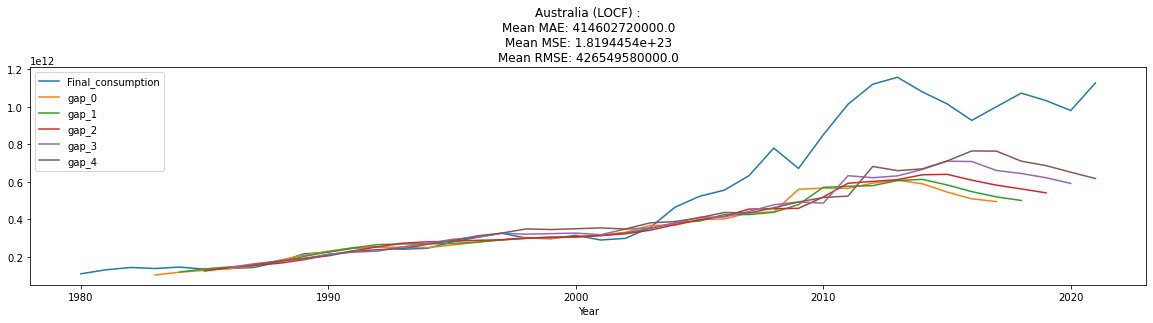

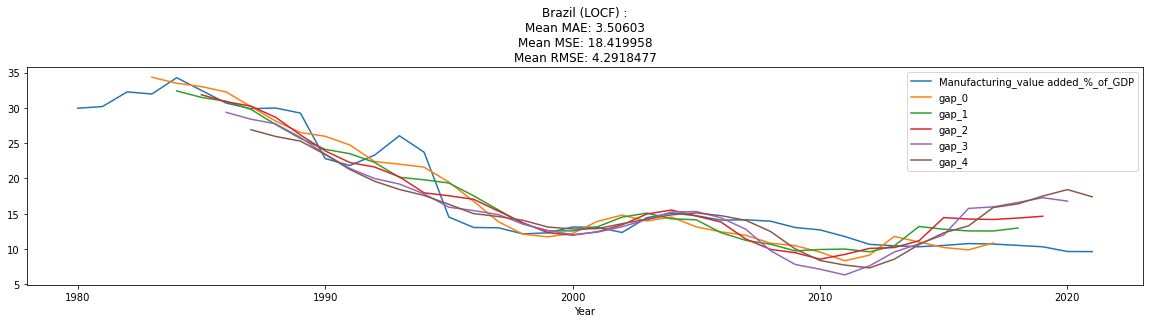

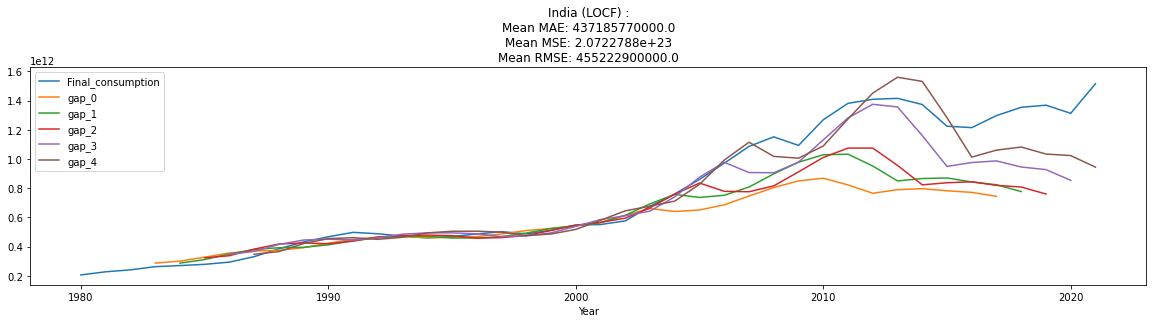

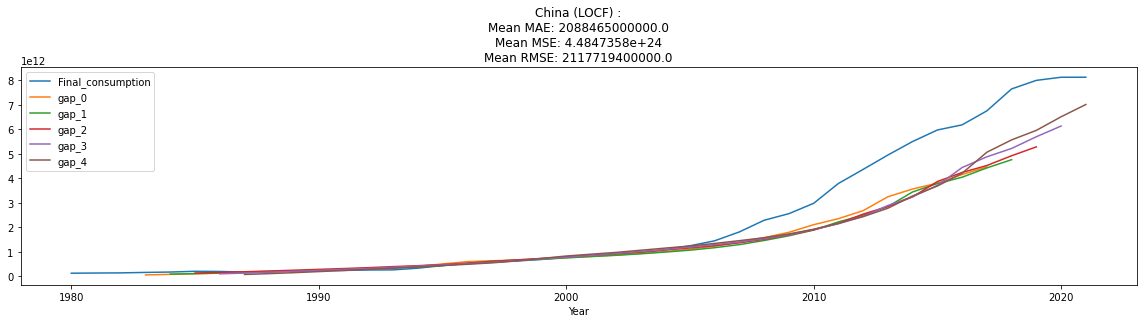

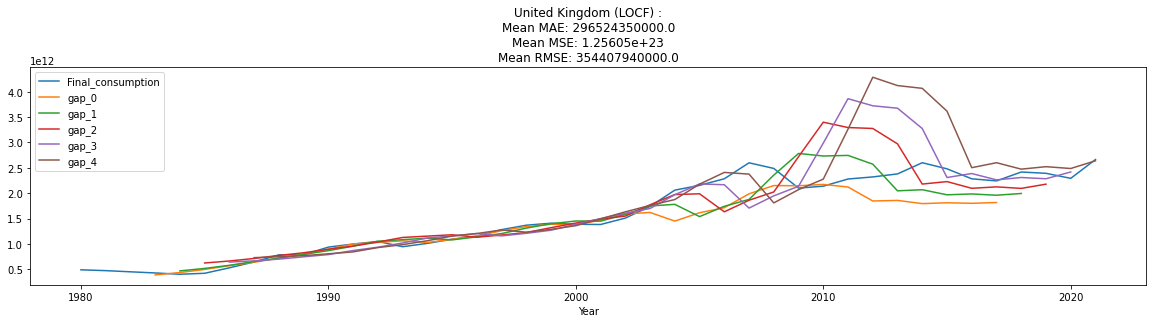

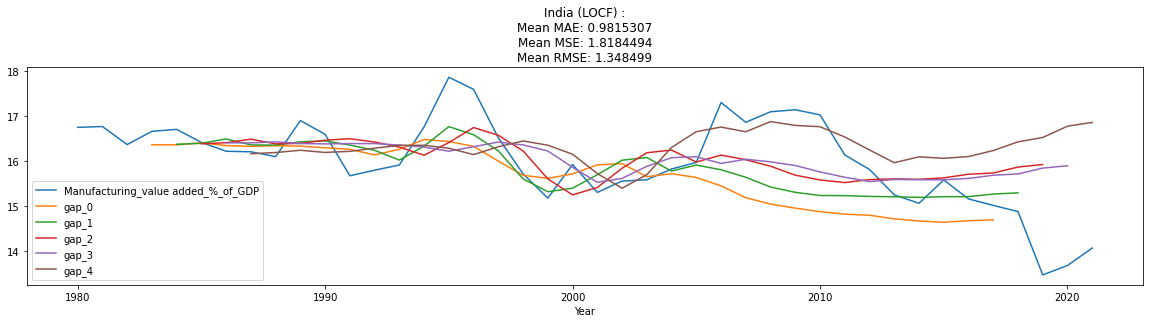

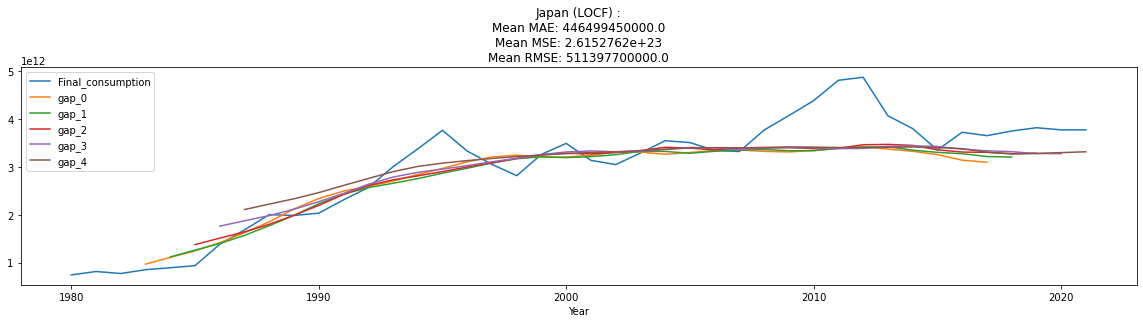

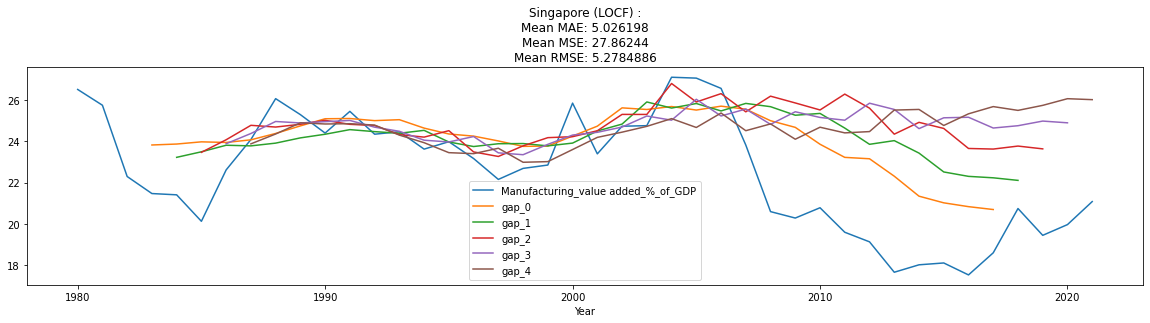

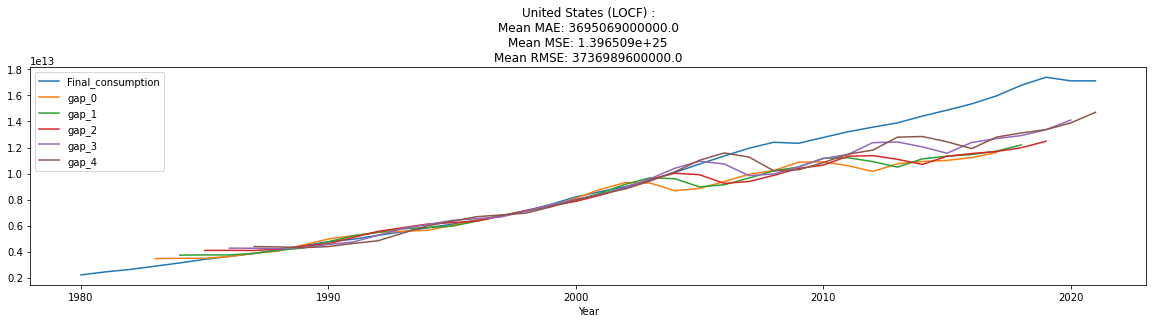

In [46]:
for sheet in get_sheet_by_methods(Data_dic_s, 2):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### NOCB

Australia NOCB :
Total Modelling Time:  11.76191520690918
MAE [6.798994, 9.023963, 7.0877156, 10.088319, 11.053018]  Mean MAE 8.810403 
MSE [47.781765, 83.3222, 51.147125, 103.548775, 124.17212]  Mean MSE 81.9944 
RMSE [6.9124355, 9.128099, 7.151722, 10.175892, 11.143254] Mean RMSE 9.055076


<AxesSubplot:title={'center':'Australia (NOCB) :\nMean MAE: 8.810403\nMean MSE: 81.9944\nMean RMSE: 9.055076'}, xlabel='Year'>

AUS_NOCB
2022  8.416178
2023  4.349052
2024  3.331114
2025  1.024848
2026 -0.146376



Brazil NOCB :
Total Modelling Time:  12.221986055374146
MAE [8.4860525, 6.198591, 0.6289714, 2.028568, 3.6123574]  Mean MAE 4.1909084 
MSE [73.31257, 39.17908, 0.44748232, 6.022527, 16.83349]  Mean MSE 27.159027 
RMSE [8.562276, 6.2593193, 0.6689412, 2.4540837, 4.102864] Mean RMSE 5.2114325


<AxesSubplot:title={'center':'Brazil (NOCB) :\nMean MAE: 4.1909084\nMean MSE: 27.159027\nMean RMSE: 5.2114325'}, xlabel='Year'>

BRA_NOCB
2022   6.006712
2023   7.002087
2024  10.203778
2025  11.275682
2026  11.545788



India NOCB :
Total Modelling Time:  12.685925722122192
MAE [369711800000.0, 325009570000.0, 217423600000.0, 118444920000.0, 116305035000.0]  Mean MAE 229379030000.0 
MSE [1.4420514e+23, 1.1663919e+23, 6.220193e+22, 2.3032453e+22, 2.7348262e+22]  Mean MSE 7.46854e+22 
RMSE [379743540000.0, 341524800000.0, 249403150000.0, 151764470000.0, 165373100000.0] Mean RMSE 273286300000.0


<AxesSubplot:title={'center':'India (NOCB) :\nMean MAE: 229379030000.0\nMean MSE: 7.46854e+22\nMean RMSE: 273286300000.0'}, xlabel='Year'>

CAN_NOCB
2022  8.094094e+11
2023  7.647802e+11
2024  7.638886e+11
2025  8.072137e+11
2026  8.616878e+11



China NOCB :
Total Modelling Time:  12.174691915512085
MAE [2.3590508, 2.967996, 3.632208, 4.325263, 4.587071]  Mean MAE 3.5743177 
MSE [7.316443, 10.101693, 14.439065, 19.505102, 21.510191]  Mean MSE 14.574498 
RMSE [2.7048924, 3.178316, 3.799877, 4.416458, 4.637908] Mean RMSE 3.817656


<AxesSubplot:title={'center':'China (NOCB) :\nMean MAE: 3.5743177\nMean MSE: 14.574498\nMean RMSE: 3.817656'}, xlabel='Year'>

CHN_NOCB
2022  31.986950
2023  31.978498
2024  32.004402
2025  32.009087
2026  32.028008



United Kingdom NOCB :
Total Modelling Time:  12.42884373664856
MAE [6.7688785, 8.523229, 7.5872655, 10.369024, 9.095304]  Mean MAE 8.4687395 
MSE [49.2049, 76.86785, 60.274067, 112.84857, 86.54771]  Mean MSE 77.14861 
RMSE [7.0146203, 8.767431, 7.7636375, 10.623021, 9.303102] Mean RMSE 8.783428


<AxesSubplot:title={'center':'United Kingdom (NOCB) :\nMean MAE: 8.4687395\nMean MSE: 77.14861\nMean RMSE: 8.783428'}, xlabel='Year'>

GBR_NOCB
2022  1.124536
2023 -0.962513
2024  0.016235
2025 -3.564524
2026 -2.172368



India NOCB :
Total Modelling Time:  12.546878814697266
MAE [1.2002903, 0.68287057, 0.41971812, 0.8815635, 2.0259135]  Mean MAE 1.0420712 
MSE [1.4965181, 0.515364, 0.5040408, 1.410655, 4.9654074]  Mean MSE 1.7783972 
RMSE [1.2233226, 0.7178886, 0.7099583, 1.18771, 2.2283194] Mean RMSE 1.3335656


<AxesSubplot:title={'center':'India (NOCB) :\nMean MAE: 1.0420712\nMean MSE: 1.7783972\nMean RMSE: 1.3335656'}, xlabel='Year'>

IND_NOCB
2022  13.829205
2023  14.217668
2024  15.083797
2025  15.832814
2026  17.420540



Japan NOCB :
Total Modelling Time:  12.37723422050476
MAE [5819.34, 3395.3074, 3530.627, 4835.8403, 5553.178]  Mean MAE 4626.8584 
MSE [52889732.0, 15053224.0, 17527312.0, 29123296.0, 33724156.0]  Mean MSE 29663544.0 
RMSE [7272.5327, 3879.8484, 4186.5635, 5396.6006, 5807.2505] Mean RMSE 5446.425


<AxesSubplot:title={'center':'Japan (NOCB) :\nMean MAE: 4626.8584\nMean MSE: 29663544.0\nMean RMSE: 5446.425'}, xlabel='Year'>

JPN_NOCB
2022  27393.523438
2023  29811.445312
2024  29949.648438
2025  30918.171875
2026  32034.560547



Singapore NOCB :
Total Modelling Time:  12.624279737472534
MAE [3.6850927, 5.321403, 6.9461284, 6.659931, 6.570913]  Mean MAE 5.8366942 
MSE [13.956844, 29.909775, 49.18756, 45.21526, 43.934433]  Mean MSE 36.440777 
RMSE [3.735886, 5.468983, 7.0133843, 6.7242293, 6.6283054] Mean RMSE 6.0366197


<AxesSubplot:title={'center':'Singapore (NOCB) :\nMean MAE: 5.8366942\nMean MSE: 36.440777\nMean RMSE: 6.0366197'}, xlabel='Year'>

SGP_NOCB
2022  18.805817
2023  20.946667
2024  23.866419
2025  25.625195
2026  27.053864



United States NOCB :
Total Modelling Time:  13.497699975967407
MAE [5995.61, 5706.857, 6105.6973, 3949.548, 4245.027]  Mean MAE 5200.548 
MSE [36319130.0, 33055430.0, 38407292.0, 19316654.0, 19695030.0]  Mean MSE 29358708.0 
RMSE [6026.535, 5749.3853, 6197.362, 4395.072, 4437.908] Mean RMSE 5418.3677


<AxesSubplot:title={'center':'United States (NOCB) :\nMean MAE: 5200.548\nMean MSE: 29358708.0\nMean RMSE: 5418.3677'}, xlabel='Year'>

USA_NOCB
2022  63428.968750
2023  69302.195312
2024  71325.679688
2025  80887.929688
2026  83523.812500

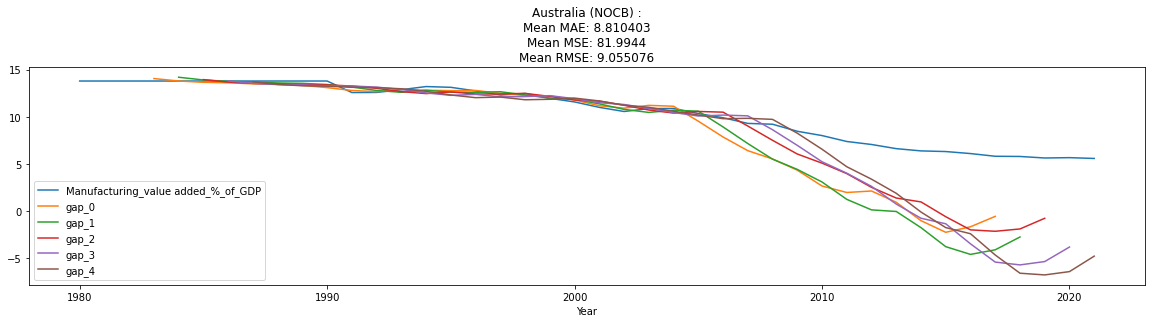

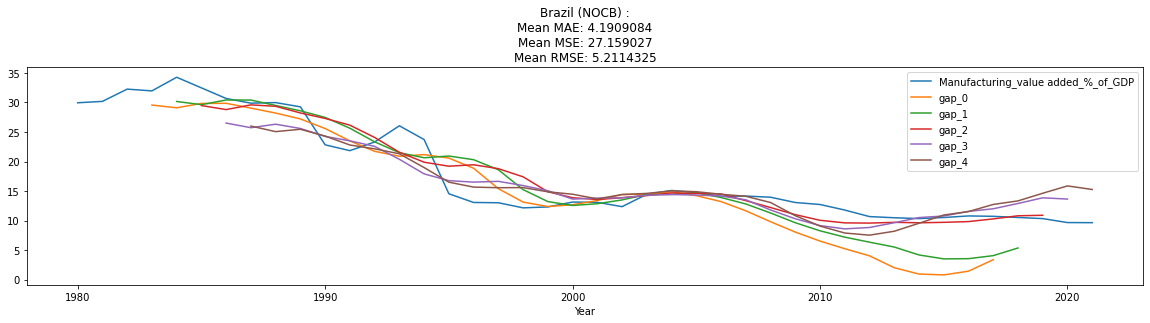

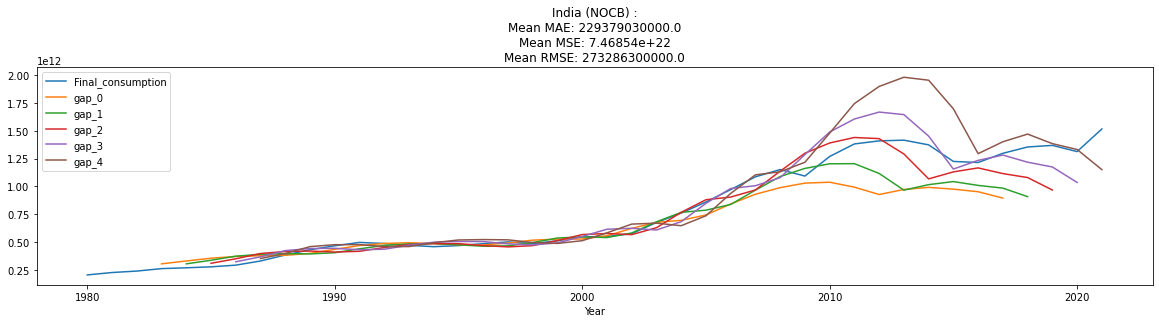

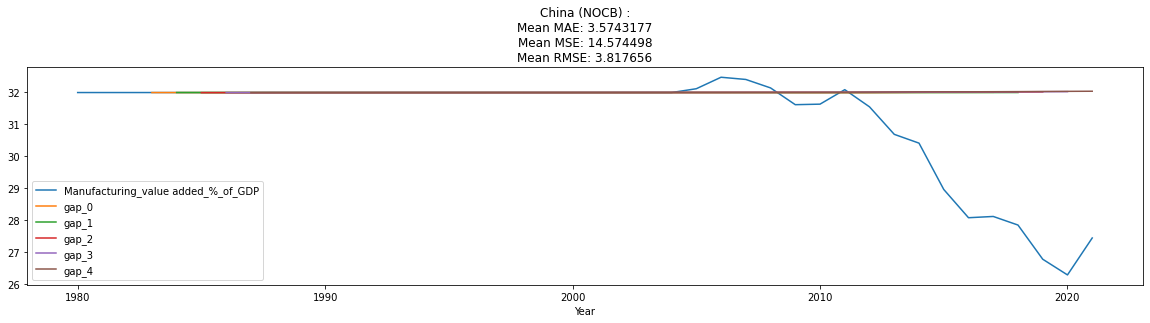

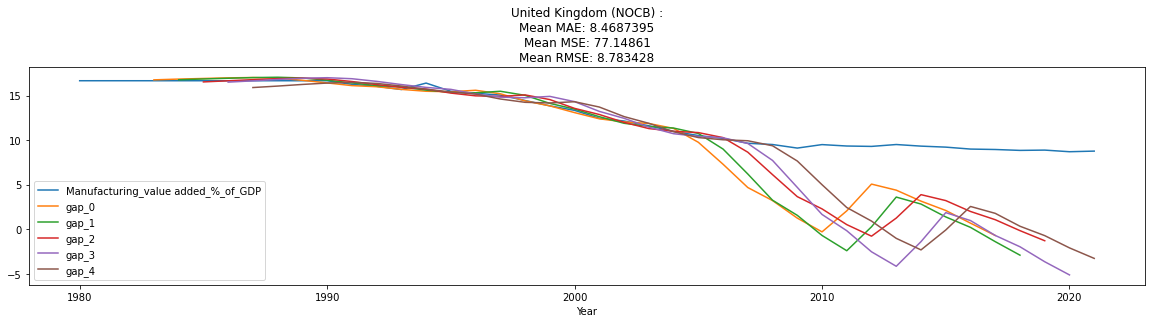

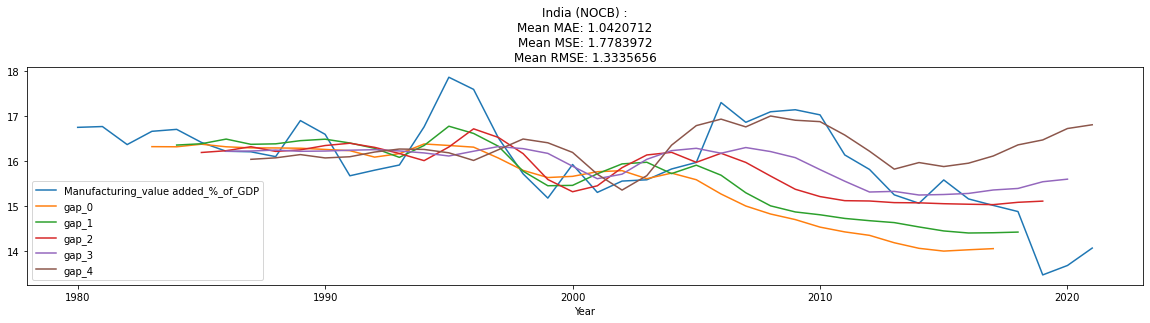

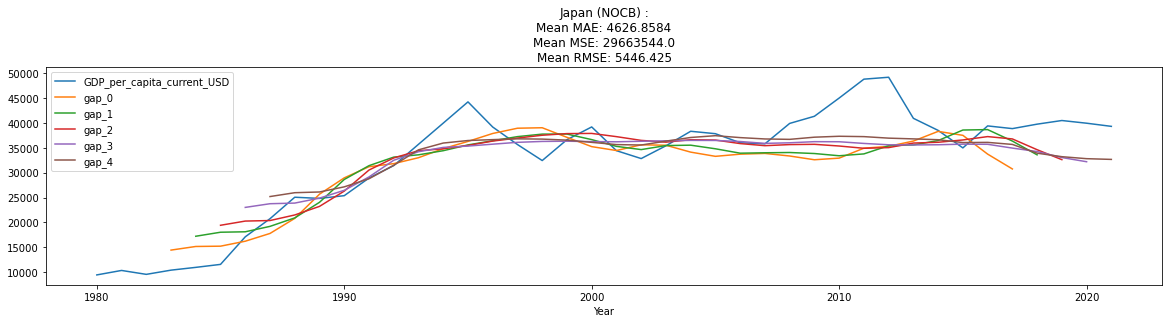

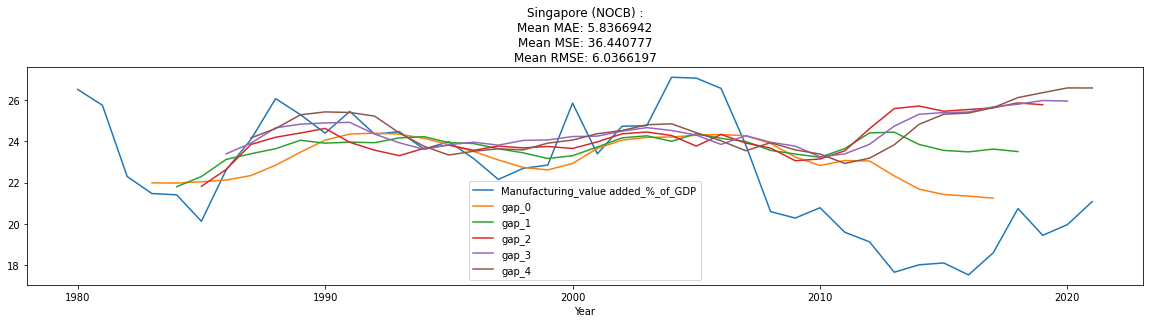

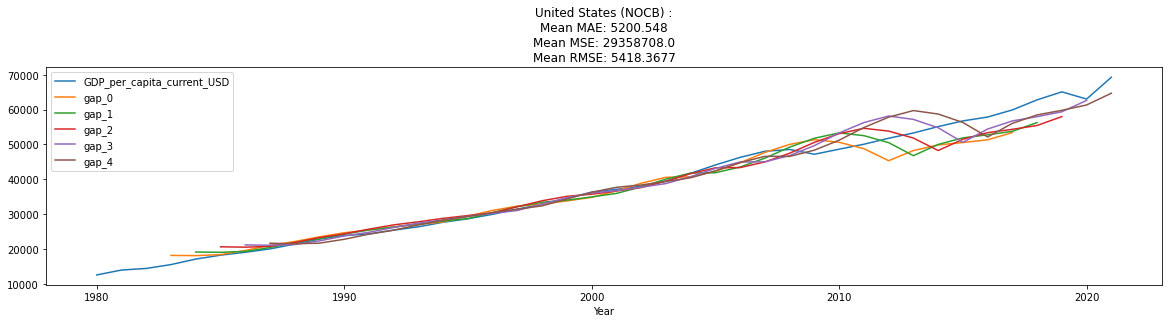

In [47]:
for sheet in get_sheet_by_methods(Data_dic_s, 3):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Rolling Stats

In [48]:
for sheet in get_sheet_by_methods(Data_dic_s, 4):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

Australia Rolling statistics :
Total Modelling Time:  13.773684978485107
MAE [329939200000.0, 342749220000.0, 364183850000.0, 345194900000.0, 308301600000.0]  Mean MAE 338073800000.0 
MSE [1.1038835e+23, 1.1812238e+23, 1.3314107e+23, 1.19465195e+23, 9.537105e+22]  Mean MSE 1.1529759e+23 
RMSE [332247430000.0, 343689360000.0, 364885020000.0, 345637400000.0, 308822050000.0] Mean RMSE 339555000000.0
Cannot handle AUS, Rolling statistics
Brazil Rolling statistics :
Total Modelling Time:  13.713913202285767
MAE [2.7228258, 2.1105819, 1.4669647, 1.0567274, 0.70012933]  Mean MAE 1.6114459 
MSE [7.9399, 4.6206717, 2.1704817, 1.2129327, 0.63975686]  Mean MSE 3.3167489 
RMSE [2.8177829, 2.1495748, 1.4732555, 1.1013322, 0.799848] Mean RMSE 1.8211943
Cannot handle BRA, Rolling statistics
India Rolling statistics :
Total Modelling Time:  14.40541696548462
MAE [528810340000.0, 513997900000.0, 502093940000.0, 453284040000.0, 426891770000.0]  Mean MAE 485015600000.0 
MSE [2.8083873e+23, 2.6499578e+23,

###### Interpolate

In [49]:
for sheet in get_sheet_by_methods(Data_dic_s, 5):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

Australia Interpolate :
Cannot handle AUS, Interpolate
Brazil Interpolate :
Cannot handle BRA, Interpolate
India Interpolate :
Cannot handle CAN, Interpolate
China Interpolate :
Cannot handle CHN, Interpolate
United Kingdom Interpolate :
Cannot handle GBR, Interpolate
India Interpolate :
Cannot handle IND, Interpolate
Japan Interpolate :
Cannot handle JPN, Interpolate
Singapore Interpolate :
Cannot handle SGP, Interpolate
United States Interpolate :
Cannot handle USA, Interpolate


###### Summary

In [50]:
pd.DataFrame({
    'country': c,
    'method': m,
    'ME': a,
    'MSE': s,
    'RMSE': r
})

country  method            ME           MSE          RMSE
0      AUS    Mean  4.916616e+00  2.730713e+01  5.225623e+00
1      BRA    Mean  1.557650e+01  2.483135e+02  1.575797e+01
2      CAN    Mean  1.059805e+00  1.720626e+00  1.311727e+00
3      CHN    Mean  1.787207e+00  3.961790e+00  1.990425e+00
4      GBR    Mean  3.058649e+00  1.403299e+01  3.746064e+00
5      IND    Mean  1.215641e+00  2.440758e+00  1.562293e+00
6      JPN    Mean  1.057653e+00  1.415542e+00  1.189765e+00
7      SGP    Mean  3.112615e+00  1.131112e+01  3.363201e+00
8      USA    Mean  5.959795e-01  4.339283e-01  6.587324e-01
9      AUS  Median  4.895869e+00  2.703007e+01  5.199045e+00
10     BRA  Median  1.010611e+01  1.105711e+02  1.051528e+01
11     CAN  Median  1.909058e+00  4.284477e+00  2.069898e+00
12     CHN  Median  2.651710e+00  8.453401e+00  2.907473e+00
13     GBR  Median  1.885538e+00  8.115286e+00  2.848734e+00
14     IND  Median  1.105120e+00  1.854626e+00  1.361846e+00
15     JPN  Median  1.052290e+00  1.393621e+00  1.180517e+00
16     SGP  Median  3.666758e+00  1.503325e+01  3.877274e+00
17     USA  Median  4.937783e-01  4.820299e-01  6.942837e-01
18     AUS    LOCF  4.146027e+11  1.819445e+23  4.265496e+11
19     BRA    LOCF  3.506030e+00  1.841996e+01  4.291848e+00
20     CAN    LOCF  4.371858e+11  2.072279e+23  4.552229e+11
21     CHN    LOCF  2.088465e+12  4.484736e+24  2.117719e+12
22     GBR    LOCF  2.965243e+11  1.256050e+23  3.544079e+11
23     IND    LOCF  9.815307e-01  1.818449e+00  1.348499e+00
24     JPN    LOCF  4.464995e+11  2.615276e+23  5.113977e+11
25     SGP    LOCF  5.026198e+00  2.786244e+01  5.278489e+00
26     USA    LOCF  3.695069e+12  1.396509e+25  3.736990e+12
27     AUS    NOCB  8.810403e+00  8.199440e+01  9.055076e+00
28     BRA    NOCB  4.190908e+00  2.715903e+01  5.211432e+00
29     CAN    NOCB  2.293790e+11  7.468540e+22  2.732863e+11
30     CHN    NOCB  3.574318e+00  1.457450e+01  3.817656e+00
31     GBR    NOCB  8.468740e+00  7.714861e+01  8.783428e+00
32     IND    NOCB  1.042071e+00  1.778397e+00  1.333566e+00
33     JPN    NOCB  4.626858e+03  2.966354e+07  5.446425e+03
34     SGP    NOCB  5.836694e+00  3.644078e+01  6.036620e+00
35     USA    NOCB  5.200548e+03  2.935871e+07  5.418368e+03